In [1]:
import collections
import gym
import numpy as np
import pandas as pd
import statistics
import tensorflow as tf
import tqdm
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple
import socket
import array
import struct
import os
from gym import Env, spaces
import time
import datetime
import random
import csv
from scipy.stats import ttest_ind
import re

In [2]:
class Actor(tf.keras.Model):
    def __init__(self, num_hidden_layers, common_layer=None):
        super().__init__()
        self.layer1 = layers.Dense(num_hidden_layers, activation="relu")
        self.layer2 = layers.Dense(num_hidden_layers, activation="relu")
        self.layer3 = layers.Dense(num_hidden_layers, activation="relu")
        if not common_layer is None:
            self.layer1 = common_layer[0]      
        self.layer_out = layers.Dense(1, activation="sigmoid")
    def call(self, x):
        x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
        x = self.layer_out(x)
        return x
class Critic(tf.keras.Model):
    def __init__(self, num_hidden_layers, common_layer=None):
        super().__init__()
        self.layer1 = layers.Dense(num_hidden_layers, activation="relu")
        self.layer2 = layers.Dense(num_hidden_layers, activation="relu")
        self.layer3 = layers.Dense(num_hidden_layers, activation="relu")
        if not common_layer is None:
            self.layer1 = common_layer[0]
        self.layer_out = layers.Dense(1, activation="sigmoid")
    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer_out(x)
        return x

In [3]:
def init_list():
    state_list = []
    reward_list = []
    Ec_list = []
    value_list = []
    g_list = []
    Uc_list = []
    return state_list, reward_list, Ec_list, value_list, g_list, Uc_list

def update_list(state_list, reward_list, Ec_list, value_list, g_list, Uc_list, state, reward, Ec, value, g, Uc):
    state_list.append(state)
    reward_list.append(reward)
    Ec_list.append(Ec)
    value_list.append(value)
    g_list.append(g)
    Uc_list.append(Uc)
    return state_list, reward_list, Ec_list, value_list, g_list, Uc_list

def print_critic_step(index, value, reward, Ec):
    print("index: {:6.2f}, value: {:6.2f}, reward: {:6.2f}, Ec: {:6.2f}".format(int(index), float(value), float(reward), float(Ec)))
    return

def no_action():
    action = np.array([[0]])
    g = 0
    Ea = 0
    return action, g, Ea

In [4]:
def train_step(action, actor, critic, actor_optimizer, critic_optimizer, gamma, value, env, manual_step_error=5, only_critic = False):
    # initialize data list
    state_list, reward_list, Ec_list, value_list, g_list, Uc_list = init_list()
    for i in range(env.actor_steps):
        enable_update_Uc = i == (env.actor_steps - 1)
        
        # step environment
        state = env._get_obs()
        error_raw = env._get_raw_error()
        Uc = env.Uc
        mean_buffer = env.get_mean_buffer() / 15
        reward = env.reward
#        g = min(0.5, float((abs(action)[0,0] * 3 + 2) * value * (1 - Uc)))
#         action = np.array([[1]]) * g
        if only_critic:
            g = 0.0
            enable_update_Uc = False
        else:
            action = actor(tf.concat([-state, action],1))
            g = min(0.5, float(abs(action)[0,0] * 3 + 5) * mean_buffer * (1 - Uc))
            action = np.array([[1]]) * g
            enable_update_Uc = True
        print("action = {}".format(action))
        print("mean_buffer = {}".format(mean_buffer))
        print("g = {}".format(g))

        reward, Uc, index = env.step(g, v=manual_step_error, enable_update_Uc=enable_update_Uc)
        g_ILC = env.get_g_ILC()
        # critic step
        value, Ec = train_critic(state, reward, action, critic, critic_optimizer, gamma, value, manual_step_error)
        
        # update data list
        state_list, reward_list, Ec_list, value_list, g_list, Uc_list = update_list(state_list, reward_list, Ec_list, value_list, g_list, Uc_list, state, reward, Ec, value, g, Uc)
        
        # print critic step output
        print_critic_step(index, value, reward, Ec)
    
    # calculate mean state reawrd as actor input
    state = np.mean(np.array(state_list),axis=0)
    reward = np.mean(reward_list)
    
    # actor step
    
#     g = min(0.5, float((abs(action)[0,0] * 3 + 2) * value * (1 - env.Uc)))
    if only_critic:
        action, g, Ea = no_action()
    else:
        action, g, Ea = train_actor(action, actor, critic, Uc, actor_optimizer, state, mean_buffer)
 

    return reward_list, value_list, action, g_list, Uc, env.eta, Ea, Ec_list, state_list, Uc_list, index, error_raw, g_ILC

In [5]:
def train_critic(state, reward, action, critic, critic_optimizer, gamma, value_prev, manual_step_error=5):    
    with tf.GradientTape() as critic_tape:
        critic_tape.watch(critic.trainable_variables)
        
        # step critic
        value = critic(tf.concat([-state, action],1)) * 2.5
        # calculate loss
        Ec = -1 / 2 * (gamma * value - (value_prev - reward)) ** 2
    
    # gradient descent
    grads = critic_tape.gradient(Ec, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables)) 
    return value, Ec

In [6]:
def train_actor(action, actor, critic, Uc, actor_optimizer, state, reward):
    with tf.GradientTape() as action_tape:
        action_tape.watch(actor.trainable_variables)
        
        # step actor
        action = actor(tf.concat([state, action],1))
        print("raw action: {}".format(action))
        action = (action * 2.5 + 4) * reward * (1 - Uc)
        g = min(0.5, float(abs(action)[0,0] * 3.5 + 4) * reward) * (1 - Uc)
        value = critic(tf.concat([-state, action],1))
        
        # activation layer
        # g = min(0.5, float((abs(action)[0,0] * 3 + 2) * value * (1 - Uc)))
        
        # compute loss
        Ea = -(value / 2.5 * (1 - Uc) + float(repr(float(action))) * Uc) ** 2
    
    # gradient descent
    grads = action_tape.gradient(Ea, actor.trainable_variables)
    actor_optimizer.apply_gradients(zip(grads, actor.trainable_variables))
    
    return action, g, Ea

In [7]:
def ILC(gamma, gain, bias, g, error):
    rmse = error[0]
    g = g * gamma + gain * rmse + bias
    if g > 0.5:
        g = 0.5
    elif g < 0:
        g = 0
    return g

In [8]:
# # Combine the datasets into a list of lists
# data = list(zip(PositiveMeanError, NegativeMeanError, PositivePeakError, NegativePeakError, g_values))

# # Define the CSV file path
# current_time = datetime.datetime.now().strftime("%m-%d-%Y_%H.%M.%S")
# csv_file = "RecordedDataILC/Andy_ILC_{}.csv".format(current_time)

# # Write the data to the CSV file
# with open(csv_file, 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['PositiveMeanError', 'NegativeMeanError', 'PositivePeakError', 'NegativePeakError', 'g_values'])  
#     writer.writerows(data)

# print(f"Data saved to {csv_file}")

In [9]:
def init_UDP():
    UDP_IP = '192.168.0.210'
    UDP_PORT = 25010
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.bind((UDP_IP, UDP_PORT))
    ROBOT_IP = '192.168.0.8'
    ROBOT_PORT = 25050
    ROBOT_COFIG = (ROBOT_IP, ROBOT_PORT)
    return sock, ROBOT_COFIG

In [10]:
class GridWorldEnv(gym.Env):
    def __init__(self, mode=""):
        self.mode = mode
        self.g = 0
        self.Uc = 1
        self._error = np.array([[0,0,0,0]])
        self._error_raw = np.array([0,0,0,0,0])
        self.reward = 0
        self.actor_steps = 1
        self.buffer = np.zeros(6)
        self.counter = 0
        self.index = 0
        self.g_ILC = 0
        self.isCatchTrial = 0
        
        # Define Uc Parameters
        self.eta = 5
        self.beta = 0.025
        self.high_Uc_buffer = np.zeros(6)
        self.low_Uc_buffer = np.zeros(100)
        self.low_Uc = 1
        self.high_Uc = 1
        self.Uc_count = 0
        self.high_Uc_buffer_size = {5:6,3.5:12,2:100}
        self.low_Uc_buffer_size = {5:100,3.5:12,2:30}
        
        
        if self.mode == "Manual":
            self.actor_steps = 2
        else:
            self.sock, self.ROBOT_CONFIG = init_UDP()
        return
        
    def _get_obs(self):
        return self._error
    
    def get_g_ILC(self):
        return self.g_ILC
    
    def _get_raw_error(self):
        return self._error_raw
    
    def update_reward(self):
        lambda_array = np.array([1, 1.5, 1, 1.5])
        self.reward = np.mean(np.multiply(lambda_array, self._error**2))
        return
    
    def update_buffer(self):
        self.buffer = np.roll(self.buffer, 1)
        self.buffer[0] = (self._error[0][0] + self._error[0][1]) * 15
        print(self.buffer)
    
    def get_mean_buffer(self):
        mean_buffer = np.mean(self.buffer)
        return mean_buffer
    
    def update_Uc_buffer(self):
        self.low_Uc_buffer = np.roll(self.low_Uc_buffer, 1)
        self.low_Uc_buffer[0] = self.Uc
        
        self.high_Uc_buffer = np.roll(self.high_Uc_buffer, 1)
        self.high_Uc_buffer[0] = self.Uc

    def get_mean_Uc_buffer(self):
        mean_Uc_buffer = np.mean(self.Uc_buffer)
        return mean_Uc_buffer
    
    def get_min_Uc_buffer(self):
        min_Uc_buffer = np.min(self.high_Uc_buffer)
        return min_Uc_buffer
    
    def get_max_Uc_buffer(self):
        max_Uc_buffer = np.max(self.low_Uc_buffer)
        return max_Uc_buffer
    
    def update_Uc(self):
        mean_buffer = self.get_mean_buffer()
        print("mean buffer = {}".format(mean_buffer))
        # Update Uc according to Eta
        if mean_buffer > self.eta:
            self.Uc -= self.beta
        if mean_buffer < self.eta:
            self.Uc += self.beta
        
        # bound Uc to [0,1]
        if self.Uc > 1:
            self.Uc = 1
        if self.Uc < 0:
            self.Uc = 0
        self.update_Uc_buffer()
        return
        
    
    def step(self, g, v=[0.5,0.5,0.5,0.5], enable_update_Uc=False):
        self.g = g
        if self.mode == "Manual":
            self._error = np.array([v])
            self.update_reward()
            self.update_buffer()
            if enable_update_Uc:
                self.update_Uc()
            return self.reward, self.Uc, self.index
        
        # Send g to Simulink
        self.sock.sendto(bytearray(struct.pack("d", self.g)), self.ROBOT_CONFIG)
        
        # Receive Error from Simulink
        received_observation = False
        while not received_observation:
            time.sleep(0.1)
            bytes, addr = self.sock.recvfrom(1024)
            data = array.array('d', bytes)
            self.index = data[0]
            
            if int(data[7]) == 0:
                self.sock.close()
                break
                
            received_observation = True
            errors = np.clip(np.abs(np.array(data[1:5], dtype=float)),a_min=None, a_max=15) / 15
            self._error_raw = np.abs(np.array(data[1:6], dtype=float))
            print(np.abs(np.array(data[1:5], dtype=float)))
            self._error = np.expand_dims(errors, axis=0)
            self.isCatchTrial = int(data[9])
            if self.isCatchTrial:
                break
            self.update_reward()
            self.update_buffer()
            self.g_ILC = data[6]

            if enable_update_Uc:
                self.update_Uc()

In [11]:
file_name = "recordedData/Andy_RL_New.csv"
file_name = "recordedData/Damiano_ILC.csv"
# file_name = "recordedData/Karen_ILC.csv"
# file_name = "recordedData/Ton_ILC_New_System.csv"
# file_name = "recordedData/Shuai_ILC.csv"
# file_name = "recordedData/Mohak_ILC.csv"
# file_name = "recordedData/Mohamed_One_Trial_New_System.csv"
data=np.loadtxt(file_name, delimiter=",", dtype=str)
error = data.T[1][1:].astype(float)
pre_train_error = error[120:180]
df = pd.read_csv("360_pre_train.csv")
# pre_train_error
# df

In [12]:
def plot_critic(env, data, ylim=[-0.5,1.0]):
    epoch_step = env.actor_steps
    index = np.arange(0,len(data) * epoch_step)
    reward = []
    value = []
    g = []
    Ea = []
    Ec = []
    for i in range(len(data)):
        reward += data[i][1]
        value += [abs(float(d)) for d in data[i][2]]
        # g += [float(data[i][4]) for n in range(epoch_step)]
        g +=  [float(d) for d in data[i][4]]
        Ea += [abs(float(data[i][6])) for n in range(epoch_step)]
        Ec += [abs(float(d)) for d in data[i][8]]
    plt.plot(index + 1, reward)
    plt.plot(index + 1, [v for v in value])
    plt.plot(index + 1, [-ec for ec in Ec])
    plt.legend(["Reward", "Value Critic", "Temporal Difference Error"])
    plt.grid(True)
    plt.xlabel("n cycles")
    plt.ylim(ylim)
    return
    
def plot_actor(env, data, ylim=[-0.5,1.0]):
    epoch_step = env.actor_steps
    index = np.arange(0,len(data) * epoch_step)
    reward = []
    value = []
    g = []
    Ea = []
    Ec = []
    for i in range(len(data)):
        reward += data[i][1]
        value += [abs(float(d)) for d in data[i][2]]
        g +=  [float(d) for d in data[i][4]]
        Ea += [abs(float(data[i][6])) for n in range(epoch_step)]
        Ec += [abs(float(d)) for d in data[i][8]]
    plt.plot(index + 1, reward)
    plt.plot(index + 1, [v for v in value])
    plt.plot(index + 1, [-ec for ec in Ea])

    plt.legend(["Reward", "Value Critic", "Value Actor"])
    plt.grid(True)
    plt.xlabel("n cycles")
#     plt.xlim([60,240])
    plt.ylim(ylim)
    
def plot_error(env, data, ylim=[-20,20]):
    epoch_step = env.actor_steps
    index = np.arange(0,len(data) * epoch_step)
    reward = []
    value = []
    g = []
    Ea = []
    Ec = []
    negativeMeanError = []
    negativePeakError = []
    positiveMeanError = []
    positivePeakError = []
    rmse = []
    for i in range(len(data)):
        reward += data[i][1]
        value += [abs(float(d)) for d in data[i][2]]
        # g += [float(data[i][4]) for n in range(epoch_step)]
        g +=  [float(d) for d in data[i][4]]
        Ea += [abs(float(data[i][6])) for n in range(epoch_step)]
        Ec += [abs(float(d)) for d in data[i][8]]
        positiveMeanError.append(float(data[i][11][0]))
        negativeMeanError.append(float(data[i][11][1]))
        positivePeakError.append(float(data[i][11][2]))
        negativePeakError.append(float(data[i][11][3]))
        rmse.append(float(data[i][11][4]))
    plt.plot(index + 1, positiveMeanError)
    plt.plot(index + 1, negativeMeanError)
#     plt.plot(index + 1, positivePeakError)
#     plt.plot(index + 1, negativePeakError)
#    plt.legend(["positiveMeanError", "negativeMeanError", "positivePeakError", "negativePeakError"])
    plt.legend(["positiveMeanError", "negativeMeanError"])
    plt.grid(True)
    plt.xlabel("n cycles")
    plt.ylim(ylim)
    
def get_data(env, data, ylim=[-0.5,1.0]):
    epoch_step = env.actor_steps
    index = np.arange(0,len(data) * epoch_step)
    reward = []
    value = []
    g = []
    Ea = []
    Ec = []
    negativeMeanError = []
    negativePeakError = []
    positiveMeanError = []
    positivePeakError = []
    rmse = []
    for i in range(len(data)):
        reward += data[i][1]
        value += [abs(float(d)) for d in data[i][2]]
        # g += [float(data[i][4]) for n in range(epoch_step)]
        g +=  [float(d) for d in data[i][4]]
        Ea += [abs(float(data[i][6])) for n in range(epoch_step)]
        Ec += [abs(float(d)) for d in data[i][8]]
        positiveMeanError.append(float(data[i][11][0]))
        negativeMeanError.append(float(data[i][11][1]))
        positivePeakError.append(float(data[i][11][2]))
        negativePeakError.append(float(data[i][11][3]))
        rmse.append(float(data[i][11][4]))
    return np.array([positiveMeanError, negativeMeanError, positivePeakError, negativePeakError, rmse]).T

In [13]:
# get_data(env, data)

In [14]:
mode = "Manual"
mode = ""

use_pretrained = True
num_hidden_units = 6

actor = Actor(num_hidden_units)
critic = Critic(num_hidden_units)
actor.build([1,5])
critic.build([1,5])
if use_pretrained:
    critic.load_weights('./360_pretrain_checkpoints/critic_checkpoint')
#     critic.load_weights('./critic_checkpoints/critic_checkpoint')
    
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
action = np.array([[0.0]])
env = GridWorldEnv(mode=mode)
gamma = 0.5
value_prev = 0
data = []

index = 172

manual_step_error = np.array([5,5,5,5,5])
if mode == "Manual":
    error_list = pre_train_error
    error_list = df.iloc[:,1:5]
    max_episodes = 60
else:
    max_episodes = 1800

for i in range(max_episodes):
    pd.DataFrame(data).to_csv('temp.csv')
    only_critic = True
    if mode == "Manual":
#         error = min(15,error_list[i % 60] / 15)
#         manual_step_error = np.array([error,error,error,error])
        manual_step_error = error_list.iloc[i % 360].tolist()
        print(manual_step_error)
        only_critic = False
    if mode != "Manual" and index > 180 and index <= 948:
        only_critic = False
    
    if mode != "Manual" and use_pretrained and index in [120]:
        critic.load_weights('./360_pretrain_checkpoints/critic_checkpoint')
    
    reward_list, value_list, action, g_list, Uc, eta, Ea, Ec_list, state_list, Uc_list, index, error_raw, g_ILC = train_step(action, actor, critic, actor_optimizer, critic_optimizer, gamma, value_prev, env, manual_step_error, only_critic=only_critic)
    data.append([i, reward_list, value_list, action, g_list, Uc, Ea, eta, Ec_list, state_list, Uc_list, error_raw, g_ILC])
    value_prev = value_list[-1]
    
    if mode == "Manual":
        print("Ea: {}, Ec: {}, value: {:6.2f}".format(float(Ea), float(Ec_list[-1]), float(value_prev)))
    else:
        print("Index: {}, Ea: {}, Ec: {}".format(int(index), float(Ea), float(Ec_list[-1])))
        print("value: {:6f}, action: {:6.2f}, Uc: {:6.2f}".format(float(value_prev), float(action), float(Uc)))
plot_critic(env, data)

action = [[0.]]
mean_buffer = 0.0
g = 0.0
[21.74062308  0.         30.63268824  0.        ]
[15.  0.  0.  0.  0.  0.]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index:   1.00, value:   0.32, reward:   0.50, Ec:  -0.22
Index: 1, Ea: 0.0, Ec: -0.21736027300357819
value: 0.318667, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.16666666666666666
g = 0.0
[0.         0.11912962 0.         0.91369389]
[ 0.11912962 15.          0.          0.          0.          0.        ]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.

[1.86425309 0.         4.05868668 0.        ]
[ 1.86425309  0.92092795  2.53537044  5.1358352   5.251554   11.90060497]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index:  13.00, value:   0.41, reward:   0.02, Ec:  -0.01
Index: 13, Ea: 0.0, Ec: -0.005249187350273132
value: 0.411273, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.3067616183827471
g = 0.0
[0.315749  0.        0.7406288 0.       ]
[0.315749   1.86425309 0.92092795 2.53537044 5.1358352  5.251554  ]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[5.66020566 0.         8.56331346 0.        ]
[5.66020566e+00 8.97497400e+00 5.00000791e+00 1.69719559e+00
 1.63934724e+00 6.36244357e-03]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index:  25.00, value:   0.25, reward:   0.12, Ec:  -0.00
Index: 25, Ea: 0.0, Ec: -0.001691596582531929
value: 0.249427, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.2553121427176091
g = 0.0
[1.4030368  0.12898062 2.20478524 1.70323226]
[1.53201743 5.66020566 8.974974   5.00000791 1.69719559 1.63934724]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0

[ 0.          7.71569924  0.         12.85997224]
[ 7.71569924  0.74163886  8.07809134 10.72735512 12.62591862  5.92920395]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index:  37.00, value:   0.36, reward:   0.37, Ec:  -0.00
Index: 37, Ea: 0.0, Ec: -0.0021275889594107866
value: 0.362107, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.5090878570618832
g = 0.0
[0.         2.02077695 0.         4.26328018]
[ 2.02077695  7.71569924  0.74163886  8.07809134 10.72735512 12.62591862]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 

[13.87707538  5.60319972 24.08061089 16.46098305]
[19.4802751  11.81939981  4.15745525  9.94845868  1.15654863  1.31103304]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index:  49.00, value:   0.50, reward:   0.89, Ec:  -0.21
Index: 49, Ea: 0.0, Ec: -0.21169498562812805
value: 0.500544, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.531924116564687
g = 0.0
[5.29698437 2.62172352 7.43196851 4.16307609]
[ 7.91870789 19.4802751  11.81939981  4.15745525  9.94845868  1.15654863]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 

[3.67285839 0.17980281 5.47531353 1.23697562]
[ 3.8526612   3.94134028  5.55627009  2.56417224 13.36892498  6.45570481]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index:  61.00, value:   0.51, reward:   0.05, Ec:  -0.02
Index: 61, Ea: 0.0, Ec: -0.018725983798503876
value: 0.508482, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.39710081777954775
g = 0.0
[0.66859086 0.         1.67590953 0.        ]
[ 0.66859086  3.8526612   3.94134028  5.55627009  2.56417224 13.36892498]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0

[1.37111056 0.16954929 2.08380723 1.64670187]
[1.54065985 8.35963158 5.04260418 1.54538728 4.25753405 2.3862136 ]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index:  73.00, value:   0.23, reward:   0.01, Ec:  -0.01
Index: 73, Ea: 0.0, Ec: -0.013253805227577686
value: 0.232347, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.2570225615456855
g = 0.0
[ 6.55418782  0.         11.58201251  0.        ]
[6.55418782 1.54065985 8.35963158 5.04260418 1.54538728 4.25753405]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[ 7.15362066  0.         10.95825237  0.        ]
[7.15362066 3.64216947 2.97955665 1.31305455 3.93894296 2.9158888 ]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index:  85.00, value:   0.26, reward:   0.19, Ec:  -0.00
Index: 85, Ea: 0.0, Ec: -0.0014964616857469082
value: 0.255356, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.2438137011104451
g = 0.0
[2.98057303 0.         6.3876495  0.        ]
[2.98057303 7.15362066 3.64216947 2.97955665 1.31305455 3.93894296]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[2.44913702 0.         3.81996669 0.        ]
[2.44913702 1.22673789 2.36552086 2.32968112 1.92619785 0.91584207]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index:  97.00, value:   0.27, reward:   0.02, Ec:  -0.00
Index: 97, Ea: 0.0, Ec: -0.004374377895146608
value: 0.265184, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.12459018668016449
g = 0.0
[0.         3.54589776 0.         6.81581076]
[3.54589776 2.44913702 1.22673789 2.36552086 2.32968112 1.92619785]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[2.08361669 0.         3.66289514 0.        ]
[2.08361669 1.74404026 0.56010671 0.46449187 0.         1.1772388 ]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index: 109.00, value:   0.28, reward:   0.02, Ec:  -0.00
Index: 109, Ea: 0.0, Ec: -0.0038958049844950438
value: 0.276101, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.06699438154632313
g = 0.0
[4.98735483 0.05603117 7.35180467 0.54089505]
[5.043386   2.08361669 1.74404026 0.56010671 0.46449187 0.        ]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[0.82106014 3.5040862  1.15997519 8.85958515]
[4.32514634 1.85488149 0.         0.56359532 5.95324952 3.49653827]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index: 121.00, value:   0.48, reward:   0.15, Ec:  -0.01
Index: 121, Ea: 0.0, Ec: -0.014818321913480759
value: 0.484095, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.179926788195639
g = 0.0
[ 0.         11.90163605  0.         16.57849766]
[11.90163605  4.32514634  1.85488149  0.          0.56359532  5.95324952]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0

[0.         1.5074629  0.         6.51509214]
[ 1.5074629   3.76999704  3.46138972  0.52936876  6.79455463 10.5686607 ]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index: 133.00, value:   0.44, reward:   0.07, Ec:  -0.02
Index: 133, Ea: 0.0, Ec: -0.019074179232120514
value: 0.442304, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.2959048196232907
g = 0.0
[0.94382121 0.86652661 1.36012745 3.38925257]
[1.81034782 1.5074629  3.76999704 3.46138972 0.52936876 6.79455463]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0.         0.50053721 0.         2.45001363]
[0.50053721 4.80754306 2.75200558 0.02250675 8.29163087 0.9491444 ]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index: 145.00, value:   0.47, reward:   0.01, Ec:  -0.01
Index: 145, Ea: 0.0, Ec: -0.014758943580091
value: 0.466900, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.19248186511859922
g = 0.0
[0.         1.69208747 0.         5.13481772]
[1.69208747 0.50053721 4.80754306 2.75200558 0.02250675 8.29163087]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0.         0.83936271 0.         2.21830884]
[0.83936271 4.95802208 2.48613323 0.8859157  0.         4.88935258]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index: 157.00, value:   0.45, reward:   0.01, Ec:  -0.01
Index: 157, Ea: 0.0, Ec: -0.013290648348629475
value: 0.447160, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.15620873677650998
g = 0.0
[0.         3.29831839 0.         8.6768546 ]
[3.29831839 0.83936271 4.95802208 2.48613323 0.8859157  0.        ]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0.74876632 0.         2.70717245 0.        ]
[0.74876632 3.37140971 4.72011833 5.6063727  2.21030027 7.17730217]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index: 169.00, value:   0.43, reward:   0.01, Ec:  -0.02
Index: 169, Ea: 0.0, Ec: -0.021857187151908875
value: 0.431257, action:   0.00, Uc:   1.00
action = [[0]]
mean_buffer = 0.2648252167043307
g = 0.0
[0.68700112 0.94528853 1.28261236 2.86697438]
[1.63228965 0.74876632 3.37140971 4.72011833 5.6063727  2.21030027]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0.         1.79058873 0.         5.48156989]
[1.79058873 1.77582241 0.2613199  0.93293895 1.80350224 9.98449081]
High_UC_buffer: [0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index: 181.00, value:   0.29, reward:   0.06, Ec:  -0.00
Index: 181, Ea: 0.0, Ec: -0.004963389132171869
value: 0.285894, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.18387403379506878
g = 0.0
[0.         3.65668626 0.         6.54177529]
[3.65668626 1.79058873 1.77582241 0.2613199  0.93293895 1.80350224]
mean buffer = 1.703476415431794
High_UC_buffer: [1. 0. 0. 0. 0. 0.]
Low_UC_buffer: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 

[ 2.19043572  5.63672129  3.55368972 19.3306525 ]
[7.82715701 1.00288062 0.01719971 0.01058155 5.25717355 2.60353951]
mean buffer = 2.7864219919198376
High_UC_buffer: [1.    1.    0.975 0.95  0.975 0.    0.    0.    0.    0.    0.    0.   ]
Low_UC_buffer: [1.    1.    0.975 0.95  0.975 0.    0.    0.    0.    0.    0.    0.   ]
ETA: 3.5
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 193.00, value:   0.30, reward:   0.45, Ec:  -0.09
raw action: [[0.53470683]]
Index: 193, Ea: -0.0, Ec: -0.08970063924789429
value: 0.302974, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.1857614661279892
g = 0.0
[0.         3.74876038 0.         8.0515162 ]
[3.74876038 7.82715701 1.00288062 0.01719971 0.01058155 5.25717355]
mean buffer = 2.9772921356845443
High_UC_buffer: [1.    1.    1.    0.975 0.95  0.975 0.    0.    0.    0.    0.    0.   ]
Low_UC_buffer: [1.    1.    1.    0.975 0.95  0.975 0.    0.    0.    0.    0.    0.   ]
ETA: 3.5
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
inde

[0.         5.41556439 0.         7.6213643 ]
[5.41556439 4.25533339 0.71900304 0.34143786 0.59722598 7.4423084 ]
mean buffer = 3.1284788407751347
High_UC_buffer: [1.    1.    1.    1.    0.975 0.95  0.975 0.95  0.925 0.95  0.975 1.   ]
Low_UC_buffer: [1.    1.    1.    1.    0.975 0.95  0.975 0.95  0.925 0.95  0.975 1.   ]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 207.00, value:   0.37, reward:   0.15, Ec:  -0.01
raw action: [[0.55837274]]
Index: 207, Ea: -0.0, Ec: -0.008324122987687588
value: 0.371936, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.20856525605167564
g = 0.0
[2.44589207 0.02500002 4.22813909 0.90496007]
[2.47089209 5.41556439 4.25533339 0.71900304 0.34143786 0.59722598]
mean buffer = 2.299909457040544
High_UC_buffer: [1.    1.    1.    1.    1.    0.975 0.95  0.975 0.95  0.925 0.95  0.975]
Low_UC_buffer: [1.    1.    1.    1.    1.    0.975 0.95  0.975 0.95  0.925 0.95  0.975]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 1.

[0.         4.36714079 0.         8.79194582]
[4.36714079 6.64469281 2.85157026 1.1190243  2.81226187 0.71963456]
mean buffer = 3.0857207630494057
High_UC_buffer: [0.925 0.95  0.975 1.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.95  0.975 1.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
inde

[1.16933815 0.52620251 2.35560604 1.59641391]
[1.69554065 5.36507999 1.10428872 1.85879813 0.76405328 3.19212475]
mean buffer = 2.3299809190940244
High_UC_buffer: [0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
inde

[0.         1.54860592 0.         4.08068413]
[1.54860592 3.00421237 0.70566673 1.95312587 1.04177904 1.47569642]
mean buffer = 1.6215143936711398
High_UC_buffer: [0.825 0.8   0.775 0.75  0.775 0.75  0.775 0.75  0.775 0.8   0.825 0.85
 0.875 0.9   0.925 0.95  0.975 1.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.825 0.8   0.775 0.75  0.775 0.75  0.775 0.75  0.775 0.8   0.825 0.85
 0.875 0.9   0.925 0.95  0.975 1.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1


[0.7021926  0.53668033 1.285543   3.12026777]
[1.23887293 2.01147775 2.27640928 1.59342389 2.89587505 2.64337073]
mean buffer = 2.1099049372329257
High_UC_buffer: [0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.825 0.8   0.775 0.75  0.775
 0.75  0.775 0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975
 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.825 0.8   0.775 0.75  0.775
 0.75  0.775 0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975
 1.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LO

[2.84489705 0.80513596 4.33670778 2.65659582]
[3.65003301 1.10323566 3.63908004 2.28302616 1.9447562  1.79927153]
mean buffer = 2.403233767238092
High_UC_buffer: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ETA: 3.5
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 249.00, value:   0.24, reward:   0.04, Ec:  -0.00
raw action: [[0.5003956]]
Index: 249, Ea: -0.0, Ec: -0.0022867033258080482
value: 0.240324, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.16021558448253945
g = 0.0
[ 0.          6.92509589  0.         11.16775387]
[6.92509589 3.65003301 1.10323566 3.63908004 2.28302616 1.9447562 ]
mean buffer = 3.257537827789768
High_UC_buffer: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Low_UC_buffer: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ETA: 3.5
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 250.00, value:   0.20, reward:   0.29, Ec:  -0.01
raw action: [[0.4773861]]
Index: 250, Ea: -0.0, Ec: -0.010676349513232708
value: 0.197314, 

[1.01251663 0.0075915  1.72118587 0.37437804]
[1.02010813 7.71993591 4.06517609 3.35798492 4.8352749  1.3712658 ]
mean buffer = 3.7282909569452554
High_UC_buffer: [0.95  0.975 1.    0.975 0.95  0.925 0.9   0.875 0.9   0.925 0.95  0.975]
Low_UC_buffer: [0.95  0.975 1.    0.975 0.95  0.925 0.9   0.875 0.9   0.925 0.95  0.975]
ETA: 3.5
MIN_UC: 0.8749999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 263.00, value:   0.33, reward:   0.00, Ec:  -0.01
raw action: [[0.5452367]]
Index: 263, Ea: -0.004819734487682581, Ec: -0.010237682610750198
value: 0.328433, action:   0.07, Uc:   0.95
action = [[0.08047082]]
mean_buffer = 0.248552730463017
g = 0.08047082383117593
[0.97203777 0.         1.64811621 0.        ]
[0.97203777 1.02010813 7.71993591 4.06517609 3.35798492 4.8352749 ]
mean buffer = 3.661752952899217
High_UC_buffer: [0.925 0.95  0.975 1.    0.975 0.95  0.925 0.9   0.875 0.9   0.925 0.95 ]
Low_UC_buffer: [0.925 0.95  0.975 1.    0.975 0.95  0.925 0.9   0.875 0.9   0.925 0.95 ]
ETA: 3.5

[ 0.          7.62005794  0.         13.71604583]
[7.62005794 3.63965536 2.14077116 1.93932633 0.01474669 0.161603  ]
mean buffer = 2.5860267474123435
High_UC_buffer: [1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    0.975 0.95  0.925]
Low_UC_buffer: [1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    0.975 0.95  0.925]
ETA: 3.5
MIN_UC: 0.8999999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 276.00, value:   0.14, reward:   0.41, Ec:  -0.04
raw action: [[0.44645625]]
Index: 276, Ea: -0.0, Ec: -0.04182007908821106
value: 0.139631, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.1724017831608229
g = 0.0
[0.8668102  0.         1.19807575 0.        ]
[0.8668102  7.62005794 3.63965536 2.14077116 1.93932633 0.01474669]
mean buffer = 2.703561280855959
High_UC_buffer: [1.    1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    0.975 0.95 ]
Low_UC_buffer: [1.    1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    0.975 0.95 ]
ETA: 3.5
MIN_UC: 0.8999999999999999
MAX_UC: 

[ 0.          7.34599435  0.         21.73488676]
[7.34599435 0.79318422 1.90769536 2.64935633 0.79826211 5.3784866 ]
mean buffer = 3.1454964951719884
High_UC_buffer: [1.    1.    1.    1.    1.    0.975 1.    1.    1.    1.    1.    1.   ]
Low_UC_buffer: [1.    1.    1.    1.    1.    0.975 1.    1.    1.    1.    1.    1.   ]
ETA: 3.5
MIN_UC: 0.975
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 290.00, value:   0.16, reward:   0.46, Ec:  -0.08
raw action: [[0.47469926]]
Index: 290, Ea: -0.0, Ec: -0.07646386325359344
value: 0.162916, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.20969976634479923
g = 0.0
[0.         1.70285045 0.         8.39366197]
[1.70285045 7.34599435 0.79318422 1.90769536 2.64935633 0.79826211]
mean buffer = 2.5328904705916053
High_UC_buffer: [1.    1.    1.    1.    1.    1.    0.975 1.    1.    1.    1.    1.   ]
Low_UC_buffer: [1.    1.    1.    1.    1.    1.    0.975 1.    1.    1.    1.    1.   ]
ETA: 3.5
MIN_UC: 0.975
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1

[0.         4.24388265 0.         6.39185463]
[4.24388265 3.13911543 1.02684156 1.37400095 0.74411072 4.41140464]
mean buffer = 2.4898926570913953
High_UC_buffer: [1.    1.    0.975 0.95  0.925 0.95  0.975 1.    0.975 1.    1.    1.   ]
Low_UC_buffer: [1.    1.    0.975 0.95  0.925 0.95  0.975 1.    0.975 1.    1.    1.   ]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 304.00, value:   0.18, reward:   0.10, Ec:  -0.00
raw action: [[0.46333444]]
Index: 304, Ea: -0.0, Ec: -0.0003109350800514221
value: 0.183885, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.16599284380609303
g = 0.0
[0.         4.47560916 0.         8.30173513]
[4.47560916 4.24388265 3.13911543 1.02684156 1.37400095 0.74411072]
mean buffer = 2.5005934103416654
High_UC_buffer: [1.    1.    1.    0.975 0.95  0.925 0.95  0.975 1.    0.975 1.    1.   ]
Low_UC_buffer: [1.    1.    1.    0.975 0.95  0.925 0.95  0.975 1.    0.975 1.    1.   ]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 

[0.         1.44759147 0.         2.72667249]
[1.44759147 3.35854525 1.70815077 2.46551684 6.56045423 3.11369509]
mean buffer = 3.1089922737640356
High_UC_buffer: [0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
in

[0.         7.26228601 0.         9.95634868]
[7.26228601e+00 8.51946627e-01 3.04194167e+00 2.80191127e+00
 4.07343791e+00 1.37141320e-03]
mean buffer = 3.0054824836173175
High_UC_buffer: [0.925 0.95  0.925 0.95  0.975 0.95  0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.95  0.925 0.95  0.975 0.95  0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.97

[0.65544702 5.17876535 1.0671496  7.90569885]
[5.83421237 1.01833242 3.96249462 0.13790211 0.99118634 1.39364835]
mean buffer = 2.2229627019469276
High_UC_buffer: [0.85  0.875 0.85  0.875 0.85  0.875 0.9   0.925 0.95  0.925 0.95  0.975
 0.95  0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.85  0.875 0.85  0.875 0.85  0.875 0.9   0.925 0.95  0.925 0.95  0.975
 0.95  0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC

[0.         0.81477834 0.         3.18086103]
[0.81477834 1.45535195 1.89542472 1.98270137 1.2451322  1.65073707]
mean buffer = 1.5073542756564777
High_UC_buffer: [0.775 0.75  0.725 0.75  0.775 0.8   0.825 0.85  0.875 0.85  0.875 0.85
 0.875 0.9   0.925 0.95  0.925 0.95  0.975 0.95  0.925 0.95  0.975 0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.775 0.75  0.725 0.75  0.775 0.8   0.825 0.85  0.875 0.85  0.875 0.85
 0.875 0.9   0.925 0.95  0.925 0.95  0.975 0.95  0.925 0.95  0.975 0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 

[0.         1.16299693 0.         3.22668275]
[1.16299693 5.05266809 1.85055433 1.76190109 1.39387627 1.33678156]
mean buffer = 2.0931297105138564
High_UC_buffer: [0.85  0.875 0.9   0.875 0.85  0.825 0.8   0.775 0.75  0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.85  0.875 0.85  0.875 0.9   0.925 0.95  0.925
 0.95  0.975 0.95  0.925 0.95  0.975 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.85  0.875 0.9   0.875 0.85  0.825 0.8   0.775 0.75  0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.85  0.875 0.85  0.875 0.9   0.925 0.95  0.925
 0.95  0.975 0.95  0.925 0.95  0.975]
ETA: 3.5
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LO

[ 2.11078618  7.97177437  3.31741131 11.5442222 ]
[10.08256054  2.91074025  5.11368746  2.31025443  1.04894001  1.10400401]
mean buffer = 3.761697785757462
High_UC_buffer: [0.95  0.975 0.95  0.925 0.9   0.875 0.9   0.925 0.95  0.975 1.    1.   ]
Low_UC_buffer: [0.95  0.975 0.95  0.925 0.9   0.875 0.9   0.925 0.95  0.975 1.    1.   ]
ETA: 3.5
MIN_UC: 0.8749999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 360.00, value:   0.12, reward:   0.35, Ec:  -0.00
raw action: [[0.45560127]]
Index: 360, Ea: -0.0017420740332454443, Ec: -0.004603217821568251
value: 0.123011, action:   0.04, Uc:   0.95
action = [[0.08189617]]
mean_buffer = 0.2507798523838308
g = 0.0818961684865055
[0.         3.62076752 0.         5.78485237]
[ 3.62076752 10.08256054  2.91074025  5.11368746  2.31025443  1.04894001]
mean buffer = 4.181158371614127
High_UC_buffer: [0.925 0.95  0.975 0.95  0.925 0.9   0.875 0.9   0.925 0.95  0.975 1.   ]
Low_UC_buffer: [0.925 0.95  0.975 0.95  0.925 0.9   0.875 0.9   0.925 0.95  0.97

[ 0.07691898  3.30787801  0.11518481 11.85419421]
[3.38479699 0.49331765 8.55082041 5.49629124 2.07476513 0.24187613]
mean buffer = 3.373644592980613
High_UC_buffer: [1.    1.    0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
Low_UC_buffer: [1.    1.    0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
ETA: 3.5
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 372.00, value:   0.14, reward:   0.25, Ec:  -0.00
raw action: [[0.46439874]]
Index: 372, Ea: -0.0, Ec: -7.333961548283696e-05
value: 0.143902, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.22490963953204088
g = 0.0
[ 1.62400667  4.87254465  2.55121336 10.22145835]
[6.49655132 3.38479699 0.49331765 8.55082041 5.49629124 2.07476513]
mean buffer = 4.416090457012685
High_UC_buffer: [0.975 1.    1.    0.975 0.    0.    0.    0.    0.    0.    0.    0.   ]
Low_UC_buffer: [0.975 1.    1.    0.975 0.    0.    0.    0.    0.    0.    0.    0.   ]
ETA: 3.5
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1

[0.         1.2006933  0.         2.68038979]
[1.2006933  0.86585476 0.04371495 2.19032882 3.45426525 6.15802965]
mean buffer = 2.3188144538616675
High_UC_buffer: [0.95  0.925 0.9   0.925 0.95  0.975 1.    1.    0.975 0.95  0.925 0.95 ]
Low_UC_buffer: [0.95  0.925 0.9   0.925 0.95  0.975 1.    1.    0.975 0.95  0.925 0.95 ]
ETA: 3.5
MIN_UC: 0.8999999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 386.00, value:   0.15, reward:   0.01, Ec:  -0.00
raw action: [[0.47150934]]
Index: 386, Ea: -0.0032430037390440702, Ec: -9.272831084672362e-05
value: 0.147256, action:   0.06, Uc:   0.95
action = [[0.04983351]]
mean_buffer = 0.1545876302574445
g = 0.04983351209973531
[0.         1.67690463 0.         3.62303442]
[1.67690463 1.2006933  0.86585476 0.04371495 2.19032882 3.45426525]
mean buffer = 1.5719602834571103
High_UC_buffer: [0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    1.    0.975 0.95  0.925]
Low_UC_buffer: [0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    1.    0.975 0.95  0.925]
ETA

[0.88852734 0.74102702 1.19806089 3.45478645]
[1.62955436 3.84896309 8.28287287 2.02663475 0.86085105 6.24557613]
mean buffer = 3.8157420427930595
High_UC_buffer: [0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
Low_UC_buffer: [0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 400.00, value:   0.23, reward:   0.02, Ec:  -0.01
raw action: [[0.4718794]]
Index: 400, Ea: -0.009348636493086815, Ec: -0.010246294550597668
value: 0.230725, action:   0.10, Uc:   0.92
action = [[0.12384118]]
mean_buffer = 0.2543828028528706
g = 0.12384117589058255
[0.94665601 0.57264546 1.36230707 3.54593942]
[1.51930147 1.62955436 3.84896309 8.28287287 2.02663475 0.86085105]
mean buffer = 3.0280296001122298
High_UC_buffer: [0.95  0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.   ]
Low_UC_buffer: [0.95  0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.   ]
ETA: 3

[1.5328363  0.93988999 1.99039819 4.41688567]
[2.47272629 3.08088897 0.40268295 2.4461176  1.83739163 8.78440744]
mean buffer = 3.170702479707663
High_UC_buffer: [0.95  0.925 0.9   0.925 0.95  0.975 1.    1.    1.    1.    0.975 0.95 ]
Low_UC_buffer: [0.95  0.925 0.9   0.925 0.95  0.975 1.    1.    1.    1.    0.975 0.95 ]
ETA: 3.5
MIN_UC: 0.8999999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 413.00, value:   0.18, reward:   0.04, Ec:  -0.00
raw action: [[0.47180936]]
Index: 413, Ea: -0.0028446775395423174, Ec: -0.0014094290090724826
value: 0.180748, action:   0.05, Uc:   0.95
action = [[0.06872388]]
mean_buffer = 0.21138016531384418
g = 0.06872388323842414
[0.         0.82084149 0.         5.51257636]
[0.82084149 2.47272629 3.08088897 0.40268295 2.4461176  1.83739163]
mean buffer = 1.8434414872003142
High_UC_buffer: [0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    1.    1.    1.    0.975]
Low_UC_buffer: [0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    1.    1.    1.    0.975]
ETA

[0.         2.43312587 0.         6.73732898]
[2.43312587 1.85245539 0.59345992 0.77063112 4.12331061 5.30261988]
mean buffer = 2.5126004644747577
High_UC_buffer: [1.    0.975 0.95  0.925 0.95  0.975 1.    1.    1.    1.    1.    0.975]
Low_UC_buffer: [1.    0.975 0.95  0.925 0.95  0.975 1.    1.    1.    1.    1.    0.975]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 426.00, value:   0.20, reward:   0.09, Ec:  -0.00
raw action: [[0.46635318]]
Index: 426, Ea: -0.0, Ec: -0.0009693904430605471
value: 0.203282, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.16750669763165052
g = 0.0
[0.         1.44254389 0.         3.48642831]
[1.44254389 2.43312587 1.85245539 0.59345992 0.77063112 4.12331061]
mean buffer = 1.869254465638891
High_UC_buffer: [1.    1.    0.975 0.95  0.925 0.95  0.975 1.    1.    1.    1.    1.   ]
Low_UC_buffer: [1.    1.    0.975 0.95  0.925 0.95  0.975 1.    1.    1.    1.    1.   ]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 1

[0.         1.22340676 0.         5.2426438 ]
[1.22340676 2.10211573 5.09462338 6.96580697 3.32713583 2.73012677]
mean buffer = 3.5738692409114736
High_UC_buffer: [0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
Low_UC_buffer: [0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 440.00, value:   0.20, reward:   0.05, Ec:  -0.00
raw action: [[0.47099462]]
Index: 440, Ea: -0.008244150318205357, Ec: -0.00459450576454401
value: 0.195810, action:   0.10, Uc:   0.92
action = [[0.11603202]]
mean_buffer = 0.23825794939409825
g = 0.11603202194464456
[2.27334353 0.04588808 3.77457897 1.13690206]
[2.31923161 1.22340676 2.10211573 5.09462338 6.96580697 3.32713583]
mean buffer = 3.5053867136658305
High_UC_buffer: [0.9   0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.   ]
Low_UC_buffer: [0.9   0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.   ]
ETA: 

[0.         3.51556767 0.         5.27255223]
[3.51556767 6.08581563 0.16620477 3.806471   2.37182732 1.91260359]
mean buffer = 2.9764149978561867
High_UC_buffer: [1.    1.    1.    1.    1.    1.    1.    1.    1.    0.975 0.95  0.925]
Low_UC_buffer: [1.    1.    1.    1.    1.    1.    1.    1.    1.    0.975 0.95  0.925]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 453.00, value:   0.25, reward:   0.07, Ec:  -0.00
raw action: [[0.44674805]]
Index: 453, Ea: -0.0, Ec: -0.001056263572536409
value: 0.246909, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.19842766652374577
g = 0.0
[3.50535809 0.         6.88413544 0.        ]
[3.50535809 3.51556767 6.08581563 0.16620477 3.806471   2.37182732]
mean buffer = 3.2418740806678312
High_UC_buffer: [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    0.975 0.95 ]
Low_UC_buffer: [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    0.975 0.95 ]
ETA: 3.5
MIN_UC: 0.95
MAX_UC: 1.0
HIGH_UC: 1


[1.03063548 0.10897356 1.63892422 2.08102762]
[1.13960905 6.83900543 7.11578626 1.39388675 4.84321335 4.30028629]
mean buffer = 4.271964521226758
High_UC_buffer: [0.95  0.975 1.    0.975 0.95  0.975 0.95  0.925 0.95  0.975 1.    1.   ]
Low_UC_buffer: [0.95  0.975 1.    0.975 0.95  0.975 0.95  0.925 0.95  0.975 1.    1.   ]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 466.00, value:   0.11, reward:   0.01, Ec:  -0.03
raw action: [[0.42111078]]
Index: 466, Ea: -0.00483896117657423, Ec: -0.03273986279964447
value: 0.110078, action:   0.07, Uc:   0.95
action = [[0.09207318]]
mean_buffer = 0.28479763474845055
g = 0.09207318201568905
[1.17168359 0.         2.15740004 0.        ]
[1.17168359 1.13960905 6.83900543 7.11578626 1.39388675 4.84321335]
mean buffer = 3.7505307391120666
High_UC_buffer: [0.925 0.95  0.975 1.    0.975 0.95  0.975 0.95  0.925 0.95  0.975 1.   ]
Low_UC_buffer: [0.925 0.95  0.975 1.    0.975 0.95  0.975 0.95  0.925 0.95  0.975 1.   ]
ETA: 3.

[0.         0.35316876 0.         2.62002294]
[0.35316876 0.         1.83124364 2.78055446 3.16351614 1.49819543]
mean buffer = 1.604446405407835
High_UC_buffer: [0.925 0.9   0.875 0.9   0.925 0.95  0.975 1.    0.975 0.95  0.925 0.95 ]
Low_UC_buffer: [0.925 0.9   0.875 0.9   0.925 0.95  0.975 1.    0.975 0.95  0.925 0.95 ]
ETA: 3.5
MIN_UC: 0.8749999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 479.00, value:   0.09, reward:   0.01, Ec:  -0.00
raw action: [[0.46637383]]
Index: 479, Ea: -0.004220017697662115, Ec: -0.00016999208310153335
value: 0.089874, action:   0.07, Uc:   0.92
action = [[0.05176345]]
mean_buffer = 0.10696309369385566
g = 0.051763447258088464
[ 8.77771999  0.57815768 12.91221053  2.16108888]
ETA: 3.5
MIN_UC: 0.8749999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 480.00, value:   0.14, reward:   0.01, Ec:  -0.00
raw action: [[0.45854682]]
Index: 480, Ea: -0.0015925654442980886, Ec: -3.513857882353477e-05
value: 0.139683, action:   0.04, Uc:   0.92
action = [[0.0

[0.         4.41843427 0.         7.00473289]
[4.41843427 1.67038375 3.97890709 3.86195422 1.69325117 0.50893579]
mean buffer = 2.6886443820852315
High_UC_buffer: [1.    1.    1.    1.    0.975 0.95  0.975 1.    1.    1.    0.975 0.95 ]
Low_UC_buffer: [1.    1.    1.    1.    0.975 0.95  0.975 1.    1.    1.    0.975 0.95 ]
ETA: 3.5
MIN_UC: 0.95
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 493.00, value:   0.21, reward:   0.11, Ec:  -0.00
raw action: [[0.4532691]]
Index: 493, Ea: -0.0, Ec: -0.004649298265576363
value: 0.206540, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.1792429588056821
g = 0.0
[ 1.90004937  4.67770948  3.09024261 10.07102125]
[6.57775885 4.41843427 1.67038375 3.97890709 3.86195422 1.69325117]
mean buffer = 3.7001148922509817
High_UC_buffer: [0.975 1.    1.    1.    1.    0.975 0.95  0.975 1.    1.    1.    0.975]
Low_UC_buffer: [0.975 1.    1.    1.    1.    0.975 0.95  0.975 1.    1.    1.    0.975]
ETA: 3.5
MIN_UC: 0.95
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
in

[1.16842316 0.39848149 1.98124111 1.92182809]
[ 1.56690465  4.32455656  3.22122076  0.50576463  0.42528691 10.55575219]
mean buffer = 3.433247614545126
High_UC_buffer: [1.    0.975 1.    1.    1.    0.975 1.    1.    0.975 0.95  0.925 0.95 ]
Low_UC_buffer: [1.    0.975 1.    1.    1.    0.975 1.    1.    0.975 0.95  0.925 0.95 ]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 506.00, value:   0.22, reward:   0.01, Ec:  -0.00
raw action: [[0.45371175]]
Index: 506, Ea: -0.0, Ec: -4.536310734692961e-05
value: 0.224424, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.2288831743030084
g = 0.0
[1.82514635 0.         3.40695934 0.        ]
[1.82514635 1.56690465 4.32455656 3.22122076 0.50576463 0.42528691]
mean buffer = 1.978146641479625
High_UC_buffer: [1.    1.    0.975 1.    1.    1.    0.975 1.    1.    0.975 0.95  0.925]
Low_UC_buffer: [1.    1.    0.975 1.    1.    1.    0.975 1.    1.    0.975 0.95  0.925]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_U

[0. 0. 0. 0.]
[0.         3.71209317 3.9227857  8.02898576 5.50597289 1.6426403 ]
mean buffer = 3.8020796354429347
High_UC_buffer: [0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
Low_UC_buffer: [0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 520.00, value:   0.18, reward:   0.00, Ec:  -0.00
raw action: [[0.4458073]]
Index: 520, Ea: -0.010598303750157356, Ec: -0.0001333890249952674
value: 0.178581, action:   0.11, Uc:   0.92
action = [[0.12152838]]
mean_buffer = 0.2534719756961957
g = 0.12152838348635306
[1.41465956 0.65265561 2.38709139 2.95336383]
[2.06731517 0.         3.71209317 3.9227857  8.02898576 5.50597289]
mean buffer = 3.8728587806801458
High_UC_buffer: [0.9   0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.   ]
Low_UC_buffer: [0.9   0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.   ]
ETA: 3.5
MIN_UC: 0.8999999999999999
M

[4.20684323 2.03488188 6.14235182 4.13245868]
[6.24172511 6.45844233 4.24936157 0.47154403 1.5889589  2.20476013]
mean buffer = 3.535798679457932
High_UC_buffer: [0.975 1.    1.    1.    1.    1.    1.    1.    1.    0.975 0.95  0.925]
Low_UC_buffer: [0.975 1.    1.    1.    1.    1.    1.    1.    1.    0.975 0.95  0.925]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 534.00, value:   0.35, reward:   0.10, Ec:  -0.00
raw action: [[0.46753094]]
Index: 534, Ea: -0.0006545351934619248, Ec: -0.003474166616797447
value: 0.347094, action:   0.02, Uc:   0.97
action = [[0.0383496]]
mean_buffer = 0.23571991196386213
g = 0.03834960305932686
[4.1664185  0.         7.03099022 0.        ]
[4.1664185  6.24172511 6.45844233 4.24936157 0.47154403 1.5889589 ]
mean buffer = 3.8627417403275017
High_UC_buffer: [0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.    0.975 0.95 ]
Low_UC_buffer: [0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.    0.975 0.95 ]
ETA: 

[2.88574477 0.         5.94408559 0.        ]
[2.88574477 0.99368781 4.52989529 2.42266293 0.99715928 0.56543836]
mean buffer = 2.0657647393533165
High_UC_buffer: [1.    1.    1.    1.    1.    0.975 0.95  0.925 0.9   0.875 0.9   0.925]
Low_UC_buffer: [1.    1.    1.    1.    1.    0.975 0.95  0.925 0.9   0.875 0.9   0.925]
ETA: 3.5
MIN_UC: 0.8749999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 547.00, value:   0.14, reward:   0.05, Ec:  -0.01
raw action: [[0.44412565]]
Index: 547, Ea: -0.0, Ec: -0.0064775352366268635
value: 0.140449, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.1377176492902211
g = 0.0
[22.6783797   0.         36.72473328  0.        ]
ETA: 3.5
MIN_UC: 0.8749999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 548.00, value:   0.13, reward:   0.05, Ec:  -0.00
raw action: [[0.43982607]]
Index: 548, Ea: -0.0, Ec: -0.0003473919350653887
value: 0.131159, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.1377176492902211
g = 0.0
[0.         0.9608

[4.68986755 0.         8.1676683  0.        ]
ETA: 3.5
MIN_UC: 0.8999999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 560.00, value:   0.13, reward:   0.01, Ec:  -0.00
raw action: [[0.44777852]]
Index: 560, Ea: -0.00012055505794705823, Ec: -0.002528765005990863
value: 0.130684, action:   0.01, Uc:   0.97
action = [[0.01354884]]
mean_buffer = 0.08377624845603597
g = 0.01354884132633987
[ 2.15459009  3.42647619  3.3783746  10.12856737]
[5.58106628 0.65482444 0.78535313 0.22430852 2.42408974 1.0609199 ]
mean buffer = 1.7884270005484855
High_UC_buffer: [1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    1.    1.    1.   ]
Low_UC_buffer: [1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    1.    1.    1.   ]
ETA: 3.5
MIN_UC: 0.8999999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 561.00, value:   0.11, reward:   0.21, Ec:  -0.01
raw action: [[0.4278266]]
Index: 561, Ea: -0.0, Ec: -0.008977032266557217
value: 0.112579, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.11

[0.94571155 0.5479985  1.80442928 1.71016137]
[1.49371005e+00 4.93948103e+00 2.06945294e+00 3.69230169e-04
 9.37149085e+00 9.44872265e-03]
mean buffer = 2.980658803948685
High_UC_buffer: [1.    1.    1.    1.    0.975 1.    0.975 0.95  0.975 1.    1.    1.   ]
Low_UC_buffer: [1.    1.    1.    1.    0.975 1.    0.975 0.95  0.975 1.    1.    1.   ]
ETA: 3.5
MIN_UC: 0.95
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 574.00, value:   0.29, reward:   0.01, Ec:  -0.00
raw action: [[0.44178674]]
Index: 574, Ea: -0.0, Ec: -0.0003056001150980592
value: 0.291168, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.19871058692991234
g = 0.0
[3.22055553 0.         5.37677715 0.        ]
[3.22055553e+00 1.49371005e+00 4.93948103e+00 2.06945294e+00
 3.69230169e-04 9.37149085e+00]
mean buffer = 3.515843271813569
High_UC_buffer: [0.975 1.    1.    1.    1.    0.975 1.    0.975 0.95  0.975 1.    1.   ]
Low_UC_buffer: [0.975 1.    1.    1.    1.    0.975 1.    0.975 0.95  0.975 1.    1.   ]
ETA: 3.5
M

[10.77412345  0.         16.81388001  0.        ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index: 588.00, value:   0.10, reward:   0.04, Ec:  -0.00
raw action: [[0.43560475]]
Index: 588, Ea: -0.0, Ec: -0.000515995838213712
value: 0.103210, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.21519912734699403
g = 0.0
[ 0.          7.79574725  0.         19.37511608]
[7.79574725 3.62824402 4.52003339 1.44313477 3.5359644  1.66740923]
mean buffer = 3.7650888416975903
High_UC_buffer: [0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.  

[1.22431096 0.21821327 2.11882171 1.9318367 ]
[1.44252424 1.41698577 0.0100775  0.34494109 2.07865827 1.36194523]
mean buffer = 1.1091886847308101
High_UC_buffer: [0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
in

action = [[0.]]
mean_buffer = 0.1144953321191128
g = 0.0
[1.47413756 0.62722394 1.90334955 2.28355694]
[2.10136151 1.07890598 1.53176985 1.99499796 1.02103239 0.62227504]
mean buffer = 1.3917237881155575
High_UC_buffer: [1.    1.    1.    1.    0.975 0.95  0.925 0.9   0.875 0.85  0.875 0.9
 0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [1.    1.    1.    1.    0.975 0.95  0.925 0.9   0.875 0.85  0.875 0.9
 0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]

[14.65279509  0.         22.86247883  0.        ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 610.00, value:   0.13, reward:   0.02, Ec:  -0.04
raw action: [[0.44821957]]
Index: 610, Ea: -0.0027125535998493433, Ec: -0.03777476027607918
value: 0.126685, action:   0.05, Uc:   0.95
action = [[0.06993188]]
mean_buffer = 0.20976465475249823
g = 0.06993188235311296
[0.         2.07646694 0.         5.32612439]
[2.07646694 1.0431457  9.87184609 0.69177006 2.95586013 2.88551777]
mean buffer = 3.2541011143872787
High_UC_buffer: [0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.    0.975
 0.95  0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.  

[0.97618273 0.         1.68138205 0.        ]
[0.97618273 1.74722764 2.50358489 2.54845759 0.32424665 3.57841292]
mean buffer = 1.946352069854969
High_UC_buffer: [0.825 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    1.    1.
 1.    1.    1.    1.    1.    0.975 0.95  0.925 0.9   0.875 0.85  0.875
 0.9   0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.825 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    1.    1.
 1.    1.    1.    1.    1.    0.975 0.95  0.925 0.9   0.875 0.85  0.875
 0.9   0.925 0.95  0.975 0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1

[0.         0.85896126 0.         3.04541999]
[0.85896126 4.96986316 0.18054498 3.88139871 0.73617213 1.28400903]
mean buffer = 1.9851582110905583
High_UC_buffer: [0.95  0.925 0.95  0.925 0.9   0.875 0.85  0.825 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.
 0.975 0.95  0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.95  0.925 0.95  0.925 0.9   0.875 0.85  0.825 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.
 0.975 0.95  0.925 0.9   0.875 0.85 ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 

[0.89127548 0.         1.20603401 0.        ]
[0.89127548 1.95140805 1.00090258 2.30061558 1.5542045  2.94097993]
mean buffer = 1.7732310195621437
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.925 0.95  0.925 0.9
 0.875 0.85  0.825 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.
 1.    1.    1.    1.    1.    1.    1.    0.975 0.95  0.925 0.9   0.875
 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.925 0.95  0.925 0.9
 0.875 0.85  0.825 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.
 1.    1.    1.    1.    1.    1.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1

action = [[0.0633746]]
mean_buffer = 0.1311609810903194
g = 0.06337459716718861
[3.27192669 0.52666392 4.78843468 5.57279761]
[3.79859061 1.33907571 0.21822081 4.10675976 0.12878171 1.4366871 ]
mean buffer = 1.83801928359694
High_UC_buffer: [0.95  0.925 0.9   0.875 0.9   0.875 0.9   0.925 0.9   0.875 0.85  0.875
 0.9   0.925 0.95  0.925 0.95  0.925 0.9   0.875 0.85  0.825 0.8   0.825
 0.85  0.875 0.9   0.925 0.95  0.975 1.    1.    1.    1.    1.    1.
 1.    1.    0.975 0.95  0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95
 0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.95  0.925 0.9   0.875 0.9   0.875 0.9   0.925 0.9   0.875 0.85  0.875
 0.9   0.925 0.95  0.925 0.95  0.925 0.9   0.875 0.85  0.825 0.8   0.825
 0.8

[0.         2.44230514 0.         5.84780212]
[2.44230514 0.71346928 1.66103567 3.13124457 2.56724819 1.66759998]
mean buffer = 2.03048380381866
High_UC_buffer: [1.    1.    1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    1.   ]
Low_UC_buffer: [1.    1.    1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    1.   ]
ETA: 3.5
MIN_UC: 0.8999999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 652.00, value:   0.10, reward:   0.07, Ec:  -0.00
raw action: [[0.4386582]]
Index: 652, Ea: -0.0, Ec: -4.0783666918287054e-05
value: 0.101207, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.13536558692124398
g = 0.0
[3.37788702 4.09667577 4.63970578 7.47902617]
[7.47456278 2.44230514 0.71346928 1.66103567 3.13124457 2.56724819]
mean buffer = 2.9983109382051922
High_UC_buffer: [1.    1.    1.    1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.   ]
Low_UC_buffer: [1.    1.    1.    1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.   ]
ETA: 3.5
MIN_UC: 0.8999999999999999
MAX_UC: 1.

[0.         0.30635775 0.         2.28763688]
[ 0.30635775  4.85357712 10.77525664  5.03304289  0.84100799  3.88378488]
mean buffer = 4.282171210149306
High_UC_buffer: [0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC:

[ 9.68316944  0.         20.9309467   0.        ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 672.00, value:   0.09, reward:   0.00, Ec:  -0.00
raw action: [[0.43346348]]
Index: 672, Ea: -0.0007988428114913404, Ec: -0.000847204471938312
value: 0.089980, action:   0.03, Uc:   0.92
action = [[0.03781238]]
mean_buffer = 0.07700580695546348
g = 0.03781238183103634
[3.72549245 0.         5.20921066 0.        ]
[3.72549245 1.05635148 2.94249491 0.78161529 0.12510583 0.01293926]
mean buffer = 1.4406665365844267
High_UC_buffer: [0.95  0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.  

[2.33120867 0.         4.7980917  0.        ]
[2.33120867 0.         1.61423352 2.84571731 0.9904122  1.58578419]
mean buffer = 1.5612259827976736
High_UC_buffer: [0.925 0.9   0.875 0.9   0.925 0.95  0.975 0.95  0.925 0.9   0.875 0.85
 0.875 0.9   0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.9   0.925 0.95  0.975 0.95  0.925 0.9   0.875 0.85
 0.875 0.9   0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 

action = [[0.02358479]]
mean_buffer = 0.14670548842318437
g = 0.023584790162799338
[0.        1.0246675 0.        4.0995074]
[1.0246675  4.29836604 2.00336183 3.8703494  0.32587815 0.78088581]
mean buffer = 2.0505847882720682
High_UC_buffer: [0.95  0.975 1.    1.    1.    0.975 0.95  0.925 0.9   0.875 0.9   0.925
 0.95  0.975 0.95  0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.95  0.975 1.    1.    1.    0.975 0.95  0.925 0.9   0.875 0.9   0.925
 0.95  0.975 0.95  0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975
 0.  

[ 0.18754561  8.52827958  0.26603545 12.16067087]
[8.71582519 1.01126012 4.0747183  0.87031256 0.30088938 0.79148038]
mean buffer = 2.627414320605706
High_UC_buffer: [0.975 1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    1.    1.
 0.975 0.95  0.925 0.9   0.875 0.9   0.925 0.95  0.975 0.95  0.925 0.9
 0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.975 1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    1.    1.
 0.975 0.95  0.925 0.9   0.875 0.9   0.925 0.95  0.975 0.95  0.925 0.9
 0.875 0.85  0.875 0.9   0.925 0.95 ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1

[0.55994531 0.23856462 0.70213409 1.57023399]
[0.79850993 1.76633057 1.73112645 0.65096679 2.96957247 3.161286  ]
mean buffer = 1.846298702348326
High_UC_buffer: [0.85  0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    0.975 0.95  0.925
 0.9   0.925 0.95  0.975 1.    1.    1.    0.975 0.95  0.925 0.9   0.875
 0.9   0.925 0.95  0.975 0.95  0.925 0.9   0.875 0.85  0.875 0.9   0.925
 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.85  0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    0.975 0.95  0.925
 0.9   0.925 0.95  0.975 1.    1.    1.    0.975 0.95  0.925 0.9   0.875
 0.9   0.925 0.95  0.975 0.95  0.925]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1


[0.         0.64594654 0.         1.6950675 ]
[0.64594654 3.01473677 2.59706625 2.78985197 1.68801254 3.41922009]
mean buffer = 2.359139026980783
High_UC_buffer: [0.8   0.825 0.85  0.875 0.9   0.875 0.85  0.825 0.85  0.875 0.9   0.925
 0.95  0.975 1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    1.
 1.    0.975 0.95  0.925 0.9   0.875 0.9   0.925 0.95  0.975 0.95  0.925
 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.8   0.825 0.85  0.875 0.9   0.875 0.85  0.825 0.85  0.875 0.9   0.925
 0.95  0.975 1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 1.    1.
 1.    0.975 0.95  0.925 0.9   0.875]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC

action = [[0.1802221]]
mean_buffer = 0.1404764128512897
g = 0.18022209994790966
[0.         0.76272445 0.         2.92630083]
[0.76272445 3.84915575 1.9046229  1.66236725 1.99814088 1.84372502]
mean buffer = 2.003456039728395
High_UC_buffer: [0.775 0.8   0.825 0.8   0.775 0.75  0.775 0.8   0.825 0.85  0.875 0.9
 0.875 0.85  0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    0.975 0.95
 0.925 0.9   0.925 0.95  0.975 1.    1.    1.    0.975 0.95  0.925 0.9
 0.875 0.9   0.925 0.95  0.975 0.95  0.925 0.9   0.875 0.85  0.875 0.9
 0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.775 0.8   0.825 0.8   0.775 0.75  0.775 0.8   0.825 0.85  0.875 0.9
 0.875 0.85  0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    0.975 0.95
 0.925 0.

action = [[0.12943422]]
mean_buffer = 0.16225213655500328
g = 0.12943422357257034
[1.64542496 0.99861405 2.50280502 2.26565576]
[2.64403902 3.63534271 4.41101934 2.09423738 1.78579986 0.91019189]
mean buffer = 2.580105033816021
High_UC_buffer: [0.85  0.875 0.9   0.875 0.85  0.825 0.8   0.775 0.8   0.825 0.8   0.775
 0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.875 0.85  0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975
 1.    1.    1.    0.975 0.95  0.925 0.9   0.875 0.9   0.925 0.95  0.975
 0.95  0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.85  0.875 0.9   0.875 0.85  0.825 0.8   0.775 0.8   0.825 0.8   0.775
 0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.875 0.85  0.825 0.85  0.8

[0.         1.42141665 0.         3.92689603]
[1.42141665 1.0060478  0.53898858 1.26638893 1.54550036 2.06512532]
mean buffer = 1.3072446065237344
High_UC_buffer: [0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.    0.   ]
Low_UC_buffer: [0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.    0.   ]
ETA: 3.5
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 734.00, value:   0.08, reward:   0.03, Ec:  -0.00
raw action: [[0.38279176]]
Index: 734, Ea: -0.0036816701758652925, Ec: -0.00034866397618316114
value: 0.084834, action:   0.07, Uc:   0.90
action = [[0.0553208]]
mean_buffer = 0.08714964043491563
g = 0.05532079695299547
[1.07513998 0.         2.19304423 0.        ]
[1.07513998 1.42141665 1.0060478  0.53898858 1.26638893 1.54550036]
mean buffer = 1.1422470494297325
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.   ]
ETA: 3.5
MIN_UC

action = [[0.]]
mean_buffer = 0.19782844057370888
g = 0.0
[0.21221594 0.08417735 0.39314246 1.33772877]
[0.2963933  1.38753715 5.90560833 1.22742956 2.9308663  6.35311831]
mean buffer = 3.016825491454154
High_UC_buffer: [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    0.975 0.95 ]
Low_UC_buffer: [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    0.975 0.95 ]
ETA: 3.5
MIN_UC: 0.95
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 748.00, value:   0.16, reward:   0.00, Ec:  -0.04
raw action: [[0.35918918]]
Index: 748, Ea: -0.0, Ec: -0.03719985485076904
value: 0.157106, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.20112169943027694
g = 0.0
[0.48428169 2.59785901 0.92272807 6.02811947]
[3.0821407  0.2963933  1.38753715 5.90560833 1.22742956 2.9308663 ]
mean buffer = 2.4716625563791603
High_UC_buffer: [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    0.975]
Low_UC_buffer: [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    0.975]
ETA

action = [[0.1501184]]
mean_buffer = 0.1920512481111575
g = 0.15011840475124924
[0.63241517 0.48559952 1.08961892 3.97626746]
[1.11801468 1.31515662 1.72347574 3.63102013 7.2635382  1.23041041]
mean buffer = 2.7136026303605543
High_UC_buffer: [0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0. 

action = [[0.0303337]]
mean_buffer = 0.09490660064848461
g = 0.03033370275484513
[1.85561697 0.         2.65146904 0.        ]
[1.85561697 2.74406292 0.5139155  2.94920941 0.89871757 1.3719739 ]
mean buffer = 1.72224938009532
High_UC_buffer: [0.975 0.95  0.925 0.9   0.875 0.85  0.825 0.85  0.875 0.9   0.925 0.95
 0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.975 0.95  0.925 0.9   0.875 0.85  0.825 0.85  0.875 0.9   0.925 0.95
 0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    

action = [[0.]]
mean_buffer = 0.08465638558965975
g = 0.0
[ 8.45563821  0.         14.17558754  0.        ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 771.00, value:   0.17, reward:   0.02, Ec:  -0.00
raw action: [[0.35502222]]
Index: 771, Ea: -0.0, Ec: -1.0705549357226118e-05
value: 0.173930, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.08465638558965975
g = 0.0
[1.0285258  0.09547114 1.33190365 1.87075342]
[1.12399694 0.71806667 0.10899403 0.03556609 1.57620667 4.7989014 ]
mean buffer = 1.393621966227564
High_UC_buffer: [1.    1.    1.    1.    1.    0.975 1.    0.975 0.95  0.925 0.9   0.875
 0.85  0.825 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.  

action = [[0.0706099]]
mean_buffer = 0.15116730177704907
g = 0.07060989711912045
[0.         1.76938275 0.         5.41485356]
[1.76938275 1.22376459 0.         2.98385137 4.77103816 1.79153451]
mean buffer = 2.0899285631076174
High_UC_buffer: [0.9   0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.
 0.975 1.    0.975 0.95  0.925 0.9   0.875 0.85  0.825 0.85  0.875 0.9
 0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.9   0.925 0.95  0.975 1.    1.    1.    1.    1.    1.    1.    1.
 0.975 1.    0.975 0.95  0.925 0.9   0.875 0.85  0.825 0.85  0.875 0.9
 0.925 0.95  

action = [[0.09953537]]
mean_buffer = 0.15665786419929134
g = 0.09953537354687716
[10.02139205  0.         16.53058105  0.        ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 786.00, value:   0.16, reward:   0.06, Ec:  -0.00
raw action: [[0.32345518]]
Index: 786, Ea: -0.004991752561181784, Ec: -0.00019534537568688393
value: 0.158924, action:   0.08, Uc:   0.90
action = [[0.10190003]]
mean_buffer = 0.15665786419929134
g = 0.10190002619141672
[0.42212532 0.9008496  0.6558339  2.68265638]
[1.32297493 3.76456006 3.78493303 1.34277555 1.44935433 0.81578661]
mean buffer = 2.0800640842563847
High_UC_buffer: [0.875 0.9   0.925 0.95  0.925 0.9   0.875 0.9   0.925 0.95  0.975 1.
 1.    1.    1.    1.    1.    1.    1.    0.975 1.    0.975 0.95  0.925
 0.9   0.875 0.85  0.825 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.

action = [[0.05554518]]
mean_buffer = 0.11642869643167858
g = 0.05554517924496483
[1.27126105 1.93426687 1.7551797  5.03137376]
[3.20552792 1.19277028 2.80573679 3.35292461 0.85522946 0.        ]
mean buffer = 1.9020315112624437
High_UC_buffer: [0.95  0.925 0.9   0.875 0.85  0.825 0.85  0.875 0.9   0.925 0.95  0.925
 0.9   0.875 0.9   0.925 0.95  0.975 1.    1.    1.    1.    1.    1.
 1.    1.    0.975 1.    0.975 0.95  0.925 0.9   0.875 0.85  0.825 0.85
 0.875 0.9   0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.95  0.925 0.9   0.875 0.85  0.825 0.85  0.875 0.9   0.925 0.95  0.925
 0.9   0.875 0.9   0.925 0.95  0.975 1.    1.    1.    1.    1.    1.
 1.   

action = [[0.12915593]]
mean_buffer = 0.13661857995710103
g = 0.1291559319123525
[ 9.51333421  0.         15.64244536  0.        ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 801.00, value:   0.11, reward:   0.03, Ec:  -0.00
raw action: [[0.34135556]]
Index: 801, Ea: -0.007677007932215929, Ec: -0.003973283804953098
value: 0.110589, action:   0.10, Uc:   0.85
action = [[0.13328623]]
mean_buffer = 0.13661857995710103
g = 0.13328623372817372
[0.         2.26627179 0.         3.5819454 ]
[2.26627179 1.64781223 2.75128932 1.0184929  1.9667736  4.84180945]
mean buffer = 2.4154082143272877
High_UC_buffer: [0.825 0.85  0.875 0.9   0.925 0.95  0.975 0.95  0.925 0.9   0.875 0.85
 0.825 0.85  0.875 0.9   0.925 0.95  0.925 0.9   0.875 0.9   0.925 0.95
 0.975 1.    1.    1.    1.    1.    1.    1.    1.    0.975 1.    0.975
 0.95  0.925 0.9   0.875 0.85  0.825 0.85  0.875 0.9   0.925 0.95  0.975
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.  

action = [[0.]]
mean_buffer = 0.19518743419095144
g = 0.0
[ 0.          7.59958079  0.         12.87653927]
[7.59958079 1.45336514 8.05062569 3.62248486 1.39682063 2.1331833 ]
mean buffer = 4.042676734466232
High_UC_buffer: [0.975 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
Low_UC_buffer: [0.975 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
ETA: 3.5
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 809.00, value:   0.17, reward:   0.37, Ec:  -0.00
raw action: [[0.32728037]]
Index: 809, Ea: -0.0005531217902898788, Ec: -9.46599925555347e-07
value: 0.165856, action:   0.02, Uc:   0.97
action = [[0.04276182]]
mean_buffer = 0.2695117822977488
g = 0.04276182064857382
[0.         0.14832156 0.         2.97750149]
[0.14832156 7.59958079 1.45336514 8.05062569 3.62248486 1.39682063]
mean buffer = 3.711866444704464
High_UC_buffer: [0.95  0.975 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
Low_UC_buffer: [0.95  0.975 1.    0.    0.    0.

action = [[0.13923903]]
mean_buffer = 0.29941852487757925
g = 0.13923903286084016
[0.2147281  0.         0.33178235 0.        ]
[0.2147281  1.64777656 5.52557644 5.45505829 1.25748986 4.08272304]
mean buffer = 3.0305587155173277
High_UC_buffer: [0.95  0.925 0.95  0.975 1.    1.    1.    0.975 0.95  0.925 0.9   0.925]
Low_UC_buffer: [0.95  0.925 0.95  0.975 1.    1.    1.    0.975 0.95  0.925 0.9   0.925]
ETA: 3.5
MIN_UC: 0.8999999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 823.00, value:   0.05, reward:   0.00, Ec:  -0.05
raw action: [[0.3434894]]
Index: 823, Ea: -0.004846709780395031, Ec: -0.04620790481567383
value: 0.048656, action:   0.07, Uc:   0.95
action = [[0.06182937]]
mean_buffer = 0.2020372477011552
g = 0.06182936965024392
[0.         0.34999244 0.         2.01725138]
[0.34999244 0.2147281  1.64777656 5.52557644 5.45505829 1.25748986]
mean buffer = 2.408436949526284
High_UC_buffer: [0.975 0.95  0.925 0.95  0.975 1.    1.    1.    0.975 0.95  0.925 0.9  ]
Low_UC_buffer: 

action = [[0.]]
mean_buffer = 0.22258258477364698
g = 0.0
[0.         0.83019304 0.         4.30630147]
[0.83019304 5.86536724 6.14660233 1.13825529 2.46116561 3.20994541]
mean buffer = 3.275254820960767
High_UC_buffer: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Low_UC_buffer: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.0
HIGH_UC: 1
LOW_UC: 1
index: 837.00, value:   0.50, reward:   0.03, Ec:  -0.03
raw action: [[0.28189263]]
Index: 837, Ea: -0.0, Ec: -0.02611321024596691
value: 0.504978, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.21835032139738444
g = 0.0
[2.06851694 2.34636784 2.9753307  4.79604366]
[4.41488478 0.83019304 5.86536724 6.14660233 1.13825529 2.46116561]
mean buffer = 3.476078048468748
High_UC_buffer: [0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.   

action = [[0.08866559]]
mean_buffer = 0.14179285298068492
g = 0.08866558981708042
[0.08427315 1.23137914 0.12695668 3.87132168]
[1.31565229 2.4543641  3.05080659 1.80669268 0.4899226  0.54468602]
mean buffer = 1.610354046352003
High_UC_buffer: [0.925 0.9   0.925 0.9   0.925 0.95  0.975 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.925 0.9   0.925 0.95  0.975 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.

action = [[0.07626316]]
mean_buffer = 0.16002727515584453
g = 0.07626316237640214
[3.49733796 0.08622337 6.54949259 2.48408827]
[3.58356133 5.37375482 0.03270803 4.67498663 0.28974876 3.91109381]
mean buffer = 2.9776422306721737
High_UC_buffer: [0.9   0.925 0.95  0.925 0.95  0.925 0.95  0.925 0.9   0.925 0.9   0.925
 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.9   0.925 0.95  0.925 0.95  0.925 0.95  0.925 0.9   0.925 0.9   0.925
 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0

action = [[0.13943622]]
mean_buffer = 0.11139215036851967
g = 0.13943621756181837
[0.         0.00469021 0.         0.41352945]
[0.00469021 1.46002401 1.00407112 1.52538802 1.51503424 2.94258481]
mean buffer = 1.4086320688562248
High_UC_buffer: [0.825 0.8   0.775 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.925 0.95
 0.925 0.95  0.925 0.9   0.925 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.825 0.8   0.775 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.925 0.95
 0.925 0.95  0.925 0.9   0.925 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0. 

action = [[0.20693447]]
mean_buffer = 0.1889733512266582
g = 0.2069344665023247
[0.         0.64469057 0.         2.16271003]
[0.64469057 1.56346492 4.84656392 1.1093316  4.05076179 2.1081234 ]
mean buffer = 2.3871560331888553
High_UC_buffer: [0.8   0.825 0.85  0.875 0.9   0.875 0.85  0.825 0.8   0.775 0.8   0.825
 0.85  0.875 0.9   0.925 0.95  0.925 0.95  0.925 0.95  0.925 0.9   0.925
 0.9   0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.8   0.825 0.85  0.875 0.9   0.875 0.85  0.825 0.8   0.775 0.8   0.825
 0.85  0.875 0.9   0.925 0.95  0.925 0.95  0.925 0.95  0.925 0.9   0.925
 0.9

action = [[0.33688341]]
mean_buffer = 0.368285143747606
g = 0.3368834102359414
[0.8003415  0.02689618 1.71691066 0.45643676]
[ 0.82723768  0.61488867  1.52745339  1.4143243   1.10625662 13.48273996]
mean buffer = 3.1621501030348256
High_UC_buffer: [0.875 0.85  0.875 0.9   0.925 0.95  0.975 1.    0.    0.    0.    0.   ]
Low_UC_buffer: [0.875 0.85  0.875 0.9   0.925 0.95  0.975 1.    0.    0.    0.    0.   ]
ETA: 3.5
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 878.00, value:   0.02, reward:   0.00, Ec:  -0.00
raw action: [[0.31728867]]
Index: 878, Ea: -0.03762811794877052, Ec: -0.00021224857482593507
value: 0.024566, action:   0.22, Uc:   0.87
action = [[0.16036965]]
mean_buffer = 0.21081000686898838
g = 0.16036965324333408
[0.         0.36180132 0.         1.52594768]
[0.36180132 0.82723768 0.61488867 1.52745339 1.4143243  1.10625662]
mean buffer = 0.9753269971971629
High_UC_buffer: [0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 1.    0.    0.    0.   ]
Low_UC_buffer: [0.9   

action = [[0.02752068]]
mean_buffer = 0.17994832169030192
g = 0.02752067620931464
[2.05354691 0.         3.87025584 0.        ]
[2.05354691 2.3206761  1.95904891 1.69380309 3.38153306 3.37888894]
mean buffer = 2.4645828354852948
High_UC_buffer: [1.    0.975 0.95  0.925 0.95  0.975 1.    1.    1.    0.975 0.95  0.925]
Low_UC_buffer: [1.    0.975 0.95  0.925 0.95  0.975 1.    1.    1.    0.975 0.95  0.925]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 891.00, value:   0.07, reward:   0.02, Ec:  -0.02
raw action: [[0.28585047]]
Index: 891, Ea: -0.0, Ec: -0.021819913759827614
value: 0.074130, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.16430552236568632
g = 0.0
[0.         0.56093055 0.         2.03919492]
[0.56093055 2.05354691 2.3206761  1.95904891 1.69380309 3.38153306]
mean buffer = 1.994923103860905
High_UC_buffer: [1.    1.    0.975 0.95  0.925 0.95  0.975 1.    1.    1.    0.975 0.95 ]
Low_UC_buffer: [1.    1.    0.975 0.95  0.925 0.95  0

action = [[0.07356741]]
mean_buffer = 0.23521611754028696
g = 0.07356741439579613
[0.         2.4030938  0.         6.31069018]
[2.4030938  2.42083428 1.82339153 3.40872848 8.2297166  4.80803492]
mean buffer = 3.848966602756217
High_UC_buffer: [0.925 0.95  0.975 0.95  0.975 1.    1.    1.    1.    1.    1.    1.   ]
Low_UC_buffer: [0.925 0.95  0.975 0.95  0.975 1.    1.    1.    1.    1.    1.    1.   ]
ETA: 3.5
MIN_UC: 0.9249999999999999
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 905.00, value:   0.50, reward:   0.08, Ec:  -0.03
raw action: [[0.23696095]]
Index: 905, Ea: -0.006538453511893749, Ec: -0.030605610460042953
value: 0.503656, action:   0.08, Uc:   0.92
action = [[0.11984633]]
mean_buffer = 0.25659777351708113
g = 0.11984633425395015
[0.95617884 1.82203203 1.34341159 4.07775647]
[2.77821087 2.4030938  2.42083428 1.82339153 3.40872848 8.2297166 ]
mean buffer = 3.510662594657163
High_UC_buffer: [0.9   0.925 0.95  0.975 0.95  0.975 1.    1.    1.    1.    1.    1.   ]
Low_UC_buffer

action = [[0.]]
mean_buffer = 0.20967068835651712
g = 0.0
[12.02240601  0.         21.70672716  0.        ]
ETA: 5.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 918.00, value:   0.06, reward:   0.11, Ec:  -0.00
raw action: [[0.22157143]]
Index: 918, Ea: -0.0, Ec: -5.547558976104483e-05
value: 0.059718, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.20967068835651712
g = 0.0
[2.72042011 0.         4.70477944 0.        ]
[2.72042011 5.8837505  0.56947147 6.99505369 0.64487737 3.23341935]
mean buffer = 3.3411654146377443
High_UC_buffer: [1. 1. 1. 1. 1. 0.]
Low_UC_buffer: [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
ETA: 5.0
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 919.00, value:   0.04, reward:   0.03,

action = [[0.]]
mean_buffer = 0.1127961916888276
g = 0.0
[0.         2.52084965 0.         5.72497452]
[2.52084965 2.8665818  0.01340048 1.41676092 0.67804206 3.0984126 ]
mean buffer = 1.7656745836665781
High_UC_buffer: [1.    1.    1.    1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 0.   ]
Low_UC_buffer: [1.    1.    1.    1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975 0.   ]
ETA: 3.5
MIN_UC: 0.0
MAX_UC: 1.0
HIGH_UC: 1
LOW_UC: 1
index: 931.00, value:   0.55, reward:   0.07, Ec:  -0.02
raw action: [[0.24150403]]
Index: 931, Ea: -0.0, Ec: -0.017969666048884392
value: 0.551425, action:   0.00, Uc:   1.00
action = [[0.]]
mean_buffer = 0.11771163891110521
g = 0.0
[ 0.          4.95037489  0.         13.67532879]
[4.95037489 2.52084965 2.8665818  0.01340048 1.41676092 0.67804206]
mean buffer = 2.0743349652972545
High_UC_buffer: [1.    1.    1.    1.    1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975]
Low_UC_buffer: [1.    1.    1.    1.    1.    0.975 0.95  0.925 0.9   0.925 0.95  0.975]

action = [[0.07979155]]
mean_buffer = 0.2536470467756467
g = 0.07979155307323584
[0.80403132 0.12327938 1.11306167 1.00993118]
[0.92731071 3.95953221 6.10990427 5.14958457 4.34304993 2.85801054]
mean buffer = 3.8912320377210254
High_UC_buffer: [0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.95  0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.

action = [[0.02718284]]
mean_buffer = 0.09049026454906174
g = 0.0
[3.12845921 1.39969034 4.75098703 2.33330779]
[4.52814954 1.95504186 2.59694091 1.14011502 1.22657275 0.61842938]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_

action = [[0]]
mean_buffer = 0.14045115299461192
g = 0.0
[0.         0.45531973 0.         5.0285048 ]
[0.45531973 3.78913143 3.6688168  1.49832573 0.37725443 1.85836572]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975

[0.         0.44467608 0.         5.48482771]
[0.44467608 1.89016455 0.6673802  1.4713938  0.16399647 4.83375778]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 964.00, value:   0.13, rewar

action = [[0]]
mean_buffer = 0.09789656855209962
g = 0.0
[1.51117907 0.22589322 2.57595131 1.37598173]
[1.73707229 3.43432832 4.14632164 0.39716115 0.         0.09596364]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975

[2.19650428 0.         4.26909487 0.        ]
[2.19650428 1.29432623 0.07491537 3.16064327 3.87122189 6.8660209 ]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 979.00, value:   0.80, rewar

action = [[0]]
mean_buffer = 0.17778270504408764
g = 0.0
[1.64833319 0.46956601 2.94873268 3.18545128]
[2.1178992  0.35642053 0.91119134 6.6259219  2.58408832 1.86715812]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975

[0.67656163 0.         1.34159519 0.        ]
[0.67656163 2.09545305 0.83977463 7.81487628 2.62140831 2.01461756]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 994.00, value:   0.12, rewar

action = [[0]]
mean_buffer = 0.17552080993428387
g = 0.0
[2.29965708 0.         4.72289616 0.        ]
[2.29965708 0.12882224 5.54628511 0.6015502  1.38656357 4.55779564]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975

action = [[0]]
mean_buffer = 0.17792488952069788
g = 0.0
[0.         3.35375822 0.         5.73933716]
[3.35375822 7.20727667 1.80083794 2.9990563  1.11963935 1.31351314]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975

action = [[0]]
mean_buffer = 0.16741610912853006
g = 0.0
[0.68673579 2.69835203 0.86314248 7.56655888]
[3.38508782 3.70062892 1.3839693  1.26610466 0.42816524 8.04695045]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975

action = [[0]]
mean_buffer = 0.19649067621486296
g = 0.0
[2.48962049 1.91687798 4.10868233 4.06821769]
[4.40649847 1.62339961 0.74072552 2.1014752  5.18999291 4.79840666]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975

action = [[0]]
mean_buffer = 0.1479507954276859
g = 0.0
[ 0.          6.57465165  0.         10.12097007]
[6.57465165 4.94781694 2.04081013 1.27282805 2.91434212 1.0856704 ]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.

action = [[0]]
mean_buffer = 0.13297089781717972
g = 0.0
[0.         0.75089627 0.         2.33390874]
[0.75089627 2.18589471 0.139702   0.95110073 2.73889814 4.81055013]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975

action = [[0]]
mean_buffer = 0.22689132881728116
g = 0.0
[0.         3.86699343 0.         8.86305236]
[3.86699343 3.2502058  0.85539613 6.02112892 4.96595389 0.01990181]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975

action = [[0]]
mean_buffer = 0.09260471781608846
g = 0.0
[3.02151562 0.         4.58547239 0.        ]
[3.02151562 2.0071628  0.65616893 3.44295576 0.13122798 1.66607199]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975

action = [[0]]
mean_buffer = 0.12792213736807087
g = 0.0
[0.         0.01695917 0.         0.66000274]
[0.01695917 4.30189898 2.29395595 1.8632102  1.8652009  0.3659762 ]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975

action = [[0]]
mean_buffer = 0.24728559695276434
g = 0.0
[0. 0. 0. 0.]
[0.         4.74411633 0.38781507 2.12107765 3.05471307 9.69978488]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 106

[0.47674678 0.00306521 0.60893086 0.18311629]
[0.47981199 0.         6.3151565  2.01733424 2.18097687 0.84649575]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 1072.00, value:   0.04, rewa

[0.         3.49945304 0.         9.41042449]
[3.49945304 0.24077455 1.33058374 0.58149607 9.3207305  0.07319417]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 1079.00, value:   0.08, rewa

[0.         0.96892765 0.         4.83098128]
[0.96892765 7.33472184 2.60919297 4.61955917 1.48047029 1.69699158]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 1086.00, value:   0.95, rewa

[1.72679122 0.16657232 2.19274554 1.17653703]
[1.89336354 1.30598743 3.67050393 0.8037836  1.20048124 0.22751682]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 1093.00, value:   0.06, rewa

[0.         3.23887627 0.         7.10556798]
[3.23887627 0.42573683 1.1901495  2.40726773 0.25136161 3.15385763]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 1100.00, value:   0.04, rewa

[0.01684694 4.53285266 0.03309466 8.25945454]
[4.5496996  2.40441677 2.6924881  6.26951741 0.15230443 0.22851142]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 1107.00, value:   0.56, rewa

[2.96058817 0.01463022 5.05477951 0.51823371]
[2.97521839 9.38184756 1.03710282 0.73782612 4.34905799 1.85800174]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 1114.00, value:   1.06, rewa

[4.19203572 0.         8.43729888 0.        ]
[4.19203572 2.46857434 7.08339721 2.04956154 3.96406817 3.46019975]
High_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Low_UC_buffer: [0.925 0.9   0.875 0.85  0.875 0.9   0.925 0.95  0.975 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 1121.00, value:   0.59, rewa

action = [[0]]
mean_buffer = 0.1452381996890382
g = 0.0
ETA: 2.0
MIN_UC: 0.0
MAX_UC: 0.975
HIGH_UC: 1
LOW_UC: 1
index: 1129.00, value:   0.01, reward:   0.03, Ec:  -0.01
Index: 1129, Ea: 0.0, Ec: -0.006104292813688517
value: 0.010501, action:   0.00, Uc:   0.92
action = [[0]]
mean_buffer = 0.1452381996890382
g = 0.0


OSError: [WinError 10038] An operation was attempted on something that is not a socket

In [ ]:
def plot_Uc_g(data, data_length=1081):
    g_list = []
    Uc_list = []
    eta_list = []
    g_list += [[float(d) for d in data[i][4]] for i in range(data_length)]
    g_list = np.array(g_list).flatten()
    Uc_list += [[float(d) for d in data[i][10]] for i in range(data_length)]
    Uc_list = np.array(Uc_list).flatten()
    eta_list += [data[i][7] for i in range(data_length)]
    Uc_list = np.array(Uc_list).flatten()
    fig, ax1 = plt.subplots()
    ax1.plot(Uc_list,color='orange')
    ax2 = ax1.twinx()
    ax2.plot(g_list)
    ax1.legend(["Uc"], loc='upper center')
    ax2.legend(["g"])
    ax1.set_ylim([0,1.1])
    ax2.set_ylim([0,0.6])
    # ax1.set_xlim([0,xlim])
    # plt.vlines(x=61, ymin=-0.5, ymax=1.0, color="r")
    # plt.vlines(x=240, ymin=-0.5, ymax=1.0, color="r")
    ax1.grid(True)
    ax1.set_ylabel("Uc")
    ax2.set_ylabel("Assistance g")
    ax1.set_xlabel("n cycles")
    plt.title("Uc / g")
    return ax1

In [ ]:
get_data(env, data)
# data[0][11][0][0]

In [ ]:
plot_error(env, data)

In [ ]:
n = 1
ax1 = plot_Uc_g(data)
ax1.set_xlim([180 * n, 180 * (n + 1)])
plt.title("Uc / g (session {})".format(n))

In [ ]:
n = 2
ax1 = plot_Uc_g(data)
ax1.set_xlim([180 * n, 180 * (n + 1)])
plt.title("Uc / g (session {})".format(n))

In [ ]:
n = 3
ax1 = plot_Uc_g(data)
ax1.set_xlim([180 * n, 180 * (n + 1)])
plt.title("Uc / g (session {})".format(n))

In [ ]:
n = 4
ax1 = plot_Uc_g(data)
ax1.set_xlim([180 * n, 180 * (n + 1)])
plt.title("Uc / g (session {})".format(n))

In [ ]:
def plot_Uc_eta(data, data_length=1081):
    g_list = []
    Uc_list = []
    eta_list = []
    g_list += [[float(d) for d in data[i][4]] for i in range(data_length)]
    g_list = np.array(g_list).flatten()
    Uc_list += [[float(d) for d in data[i][10]] for i in range(data_length)]
    Uc_list = np.array(Uc_list).flatten()
    eta_list += [data[i][7] for i in range(data_length)]
    Uc_list = np.array(Uc_list).flatten()

    fig, ax1 = plt.subplots()
    ax1.plot(Uc_list,color='orange')
    ax2 = ax1.twinx()
    # ax2.plot(err)
    ax2.plot(eta_list, color="g")
    ax1.legend(["Uc"], loc='upper center')
    ax2.legend(["eta", "eta"])
    ax1.set_ylim([0,1.1])
    ax2.set_ylim([0,6])
    # ax1.set_xlim([0,xlim])
    # plt.vlines(x=61, ymin=-0.5, ymax=1.0, color="r")
    # plt.vlines(x=240, ymin=-0.5, ymax=1.0, color="r")
    ax1.grid(True)
    ax1.set_ylabel("Uc")
    ax2.set_ylabel("eta")
    ax1.set_xlabel("n cycles")
    plt.title("Uc / eta")
    return ax1

In [ ]:
n = 1
ax1 = plot_Uc_eta(data)
ax1.set_xlim([180 * n, 180 * (n + 1)])
plt.title("Uc / eta (session {})".format(n))

In [ ]:
n = 2
ax1 = plot_Uc_eta(data)
ax1.set_xlim([180 * n, 180 * (n + 1)])
plt.title("Uc / eta (session {})".format(n))

In [ ]:
n = 3
ax1 = plot_Uc_eta(data)
ax1.set_xlim([180 * n, 180 * (n + 1)])
plt.title("Uc / eta (session {})".format(n))

In [ ]:
n = 4
ax1 = plot_Uc_eta(data)
ax1.set_xlim([180 * n, 180 * (n + 1)])
plt.title("Uc / eta (session {})".format(n))

In [ ]:
plt.figure(figsize=(8, 10))
for i in range(1,5):
    plt.subplot(4,1,i)
    plt.title("training session " + str(i))
    plot_actor(env, data)
    n = i
    plt.xlim([180 * n, 180 * (n + 1)])
    plt.tight_layout()

In [ ]:
plt.figure(figsize=(8, 10))
for i in range(1,5):
    plt.subplot(4,1,i)
    plt.title("training session " + str(i))
    plot_critic(env, data)
    n = i
    plt.xlim([180 * n, 180 * (n + 1)])
    plt.tight_layout()

In [ ]:
plt.figure(figsize=(8, 10))
for i in range(1,5):
    plt.subplot(4,1,i)
    plt.title("training session " + str(i))
    plot_error(env, data)
    n = i
    plt.xlim([180 * n, 180 * (n + 1)])
    plt.tight_layout()

In [ ]:
total_err = np.array(mean_err + ((df.iloc[1:,11] + df.iloc[1:,12]) / 2).tolist())
np.savetxt("Shuai_error.csv", total_err, delimiter=",")

In [ ]:
df = pd.read_csv("RecordedDataILC/Shuai_ILC_07-01-2023_17.43.41.csv")

# rmse = df.iloc[:,10]
rmse = total_err

positiveMeanPreTrain = rmse[121:181]
positiveMeanPostTrain1 = rmse[949:1009]
positiveMeanPostTrain2 = rmse[1009:1069]
positiveMeanPostTrain3 = rmse[1069:1129]

positiveMeanPreTrain[positiveMeanPreTrain >= 10] = 5
positiveMeanPostTrain1[positiveMeanPostTrain1 >= 10] = 5
positiveMeanPostTrain2[positiveMeanPostTrain2 >= 10] = 5
positiveMeanPostTrain3[positiveMeanPostTrain3 >= 10] = 5



print(np.mean(positiveMeanPreTrain))
print(np.mean(positiveMeanPostTrain1))
print(np.mean(positiveMeanPostTrain2))
print(np.mean(positiveMeanPostTrain3))
print()
print(np.std(positiveMeanPreTrain) / np.sqrt(60))
print(np.std(positiveMeanPostTrain1) / np.sqrt(60))
print(np.std(positiveMeanPostTrain2) / np.sqrt(60))
print(np.std(positiveMeanPostTrain3) / np.sqrt(60))

In [ ]:
# new_df = pd.DataFrame([positiveMeanPreTrain, positiveMeanPostTrain1, positiveMeanPostTrain2, positiveMeanPostTrain3]).T

In [ ]:
# new_df.to_csv("rmse_compare.csv")

In [ ]:
ttest_ind(positiveMeanPreTrain, positiveMeanPostTrain1)

In [ ]:
np.std(positiveMeanPreTrain) / np.sqrt(60)

In [ ]:
np.mean(positiveMeanPreTrain)

In [ ]:
positiveMeanPreTrain[positiveMeanPreTrain >= 10] = 5

meanPre = 3.54, sePre = 0.39
meanPost1 = 2.00, sePost1 = 0.23
meanPost2 = 2.43, sePost2 = 0.26
meanPost3 = 2.55, sePost3 = 0.31


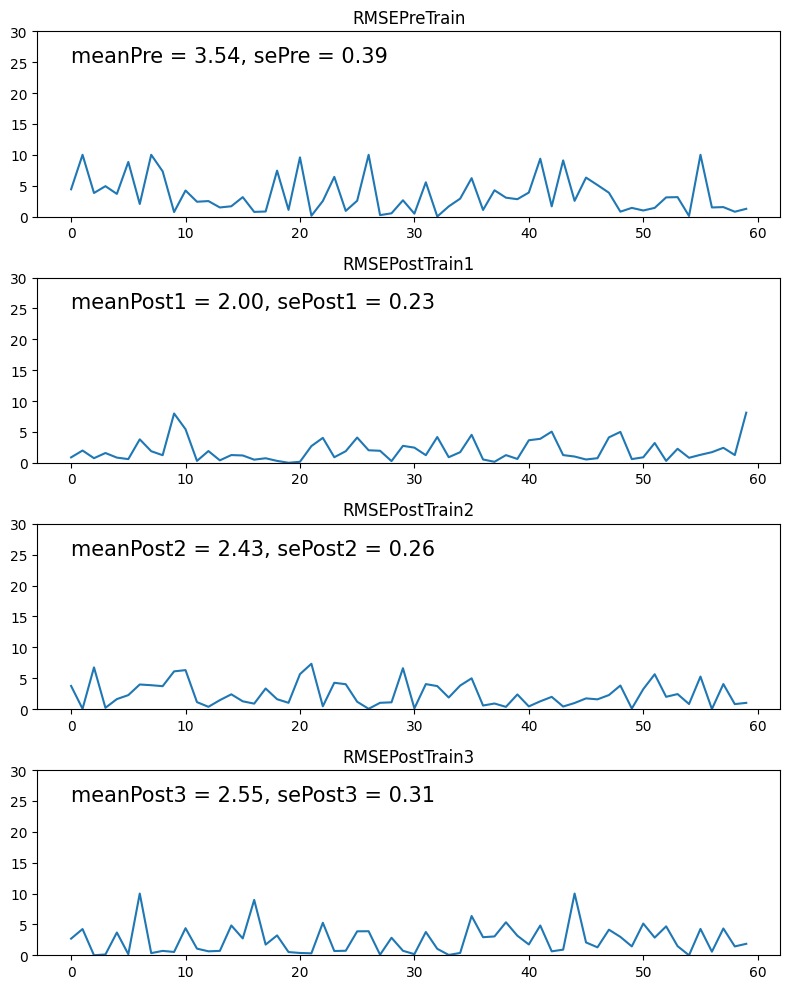

In [15]:
# PLOT RMSE

start_post_train = 948 + 1
n_test = 60


plt.figure(figsize=(8, 10))
positiveMeanPreTrain = get_data(env, data)[121:181,4]
positiveMeanPreTrain[positiveMeanPreTrain >= 10] = 10

ax1 = plt.subplot(4,1,1)
ax1.plot(positiveMeanPreTrain)
ax1.set_title("RMSEPreTrain")
ax1.set_ylim([0, 30])
preCT =  [i - 1 for i in [8, 16, 22, 32, 41, 59]]
preCT =  []
# ax1.scatter(preCT,positiveMeanPreTrain[preCT],c="orange")

positiveMeanPreTrainCT = np.delete(positiveMeanPreTrain, preCT, 0)
meanPre = np.mean(positiveMeanPreTrainCT)
sePre = np.std(positiveMeanPreTrainCT) / np.sqrt(np.size(positiveMeanPreTrainCT))
print("meanPre = {:.2f}, sePre = {:.2f}".format(meanPre, sePre))
ax1.text(0, 25, "meanPre = {:.2f}, sePre = {:.2f}".format(meanPre, sePre), fontsize=15)

positiveMeanPostTrain1 = get_data(env, data)[start_post_train:start_post_train + n_test,4]
positiveMeanPostTrain1[positiveMeanPostTrain1 >= 10] = 10
ax2 = plt.subplot(4,1,2)
ax2.plot(positiveMeanPostTrain1)
ax2.set_title("RMSEPostTrain1")
ax2.set_ylim([0, 30])
positiveMeanPostTrain1CT = positiveMeanPostTrain1
meanPost = np.mean(positiveMeanPostTrain1CT)
sePost = np.std(positiveMeanPostTrain1CT) / np.sqrt(np.size(positiveMeanPostTrain1CT))
print("meanPost1 = {:.2f}, sePost1 = {:.2f}".format(meanPost, sePost))
ax2.text(0, 25, "meanPost1 = {:.2f}, sePost1 = {:.2f}".format(meanPost, sePost), fontsize=15)

positiveMeanPostTrain2 = get_data(env, data)[start_post_train + n_test:start_post_train + n_test * 2,4]
positiveMeanPostTrain2[positiveMeanPostTrain2 >= 10] = 10
ax3 = plt.subplot(4,1,3)
ax3.plot(positiveMeanPostTrain2)
ax3.set_title("RMSEPostTrain2")
ax3.set_ylim([0, 30])
positiveMeanPostTrain2CT = positiveMeanPostTrain2
meanPost = np.mean(positiveMeanPostTrain2CT)
sePost = np.std(positiveMeanPostTrain2CT) / np.sqrt(np.size(positiveMeanPostTrain2CT))
print("meanPost2 = {:.2f}, sePost2 = {:.2f}".format(meanPost, sePost))
ax3.text(0, 25, "meanPost2 = {:.2f}, sePost2 = {:.2f}".format(meanPost, sePost), fontsize=15)

positiveMeanPostTrain3 = get_data(env, data)[start_post_train + n_test * 2:start_post_train + n_test * 3,4]
positiveMeanPostTrain3[positiveMeanPostTrain3 >= 10] = 10
ax4 = plt.subplot(4,1,4)
ax4.plot(positiveMeanPostTrain3)
ax4.set_title("RMSEPostTrain3")
ax4.set_ylim([0, 30])
positiveMeanPostTrain3CT = positiveMeanPostTrain3
meanPost = np.mean(positiveMeanPostTrain3CT)
sePost = np.std(positiveMeanPostTrain3CT) / np.sqrt(np.size(positiveMeanPostTrain3CT))
print("meanPost3 = {:.2f}, sePost3 = {:.2f}".format(meanPost, sePost))
ax4.text(0, 25, "meanPost3 = {:.2f}, sePost3 = {:.2f}".format(meanPost, sePost), fontsize=15)


plt.tight_layout()

In [ ]:
plt.figure(figsize=(8, 10))
positiveMeanPreTrain = get_data(env, data)[121:181,0] + np.abs(get_data(env, data)[121:181,1])
ax1 = plt.subplot(4,1,1)
ax1.plot(positiveMeanPreTrain)
ax1.set_title("MeanPreTrain")
ax1.set_ylim([0, 30])
preCT =  [i - 1 for i in [8, 16, 22, 32, 41, 59]]
preCT =  []
ax1.scatter(preCT,positiveMeanPreTrain[preCT],c="orange")

positiveMeanPreTrainCT = np.delete(positiveMeanPreTrain, preCT, 0)
meanPre = np.mean(positiveMeanPreTrainCT)
sePre = np.std(positiveMeanPreTrainCT) / np.sqrt(np.size(positiveMeanPreTrainCT))
print("meanPre = {:.2f}, sePre = {:.2f}".format(meanPre, sePre))
ax1.text(0, 25, "meanPre = {:.2f}, sePre = {:.2f}".format(meanPre, sePre), fontsize=15)

positiveMeanPostTrain1 = get_data(env, data)[901:961,0] + np.abs(get_data(env, data)[901:961,1])
ax2 = plt.subplot(4,1,2)
ax2.plot(positiveMeanPostTrain1)
ax2.set_title("MeanPostTrain1")
ax2.set_ylim([0, 30])
positiveMeanPostTrain1CT = positiveMeanPostTrain1
meanPost = np.mean(positiveMeanPostTrain1CT)
sePost = np.std(positiveMeanPostTrain1CT) / np.sqrt(np.size(positiveMeanPostTrain1CT))
print("meanPost1 = {:.2f}, sePost1 = {:.2f}".format(meanPost, sePost))
ax2.text(0, 25, "meanPost1 = {:.2f}, sePost1 = {:.2f}".format(meanPost, sePost), fontsize=15)

positiveMeanPostTrain2 = get_data(env, data)[961:1021,0] + np.abs(get_data(env, data)[961:1021,1])
ax3 = plt.subplot(4,1,3)
ax3.plot(positiveMeanPostTrain2)
ax3.set_title("MeanPostTrain2")
ax3.set_ylim([0, 30])
positiveMeanPostTrain2CT = positiveMeanPostTrain2
meanPost = np.mean(positiveMeanPostTrain2CT)
sePost = np.std(positiveMeanPostTrain2CT) / np.sqrt(np.size(positiveMeanPostTrain2CT))
print("meanPost2 = {:.2f}, sePost2 = {:.2f}".format(meanPost, sePost))
ax3.text(0, 25, "meanPost2 = {:.2f}, sePost2 = {:.2f}".format(meanPost, sePost), fontsize=15)

positiveMeanPostTrain3 = get_data(env, data)[1021:1081,0] + np.abs(get_data(env, data)[1021:1081,1])
ax4 = plt.subplot(4,1,4)
ax4.plot(positiveMeanPostTrain3)
ax4.set_title("MeanPostTrain3")
ax4.set_ylim([0, 30])
positiveMeanPostTrain3CT = positiveMeanPostTrain3
meanPost = np.mean(positiveMeanPostTrain3CT)
sePost = np.std(positiveMeanPostTrain3CT) / np.sqrt(np.size(positiveMeanPostTrain3CT))
print("meanPost3 = {:.2f}, sePost3 = {:.2f}".format(meanPost, sePost))
ax4.text(0, 25, "meanPost3 = {:.2f}, sePost3 = {:.2f}".format(meanPost, sePost), fontsize=15)


plt.tight_layout()

In [ ]:
plt.figure(figsize=(8, 10))
positiveMeanPreTrain = get_data(env, data)[121:181,0]
ax1 = plt.subplot(4,1,1)
ax1.plot(positiveMeanPreTrain)
ax1.set_title("positiveMeanPreTrain")
ax1.set_ylim([0, 16])
preCT =  [i - 1 for i in [8, 16, 22, 32, 41, 59]]
preCT =  []
ax1.scatter(preCT,positiveMeanPreTrain[preCT],c="orange")

positiveMeanPreTrainCT = np.delete(positiveMeanPreTrain, preCT, 0)
meanPre = np.mean(positiveMeanPreTrainCT)
sePre = np.std(positiveMeanPreTrainCT) / np.sqrt(np.size(positiveMeanPreTrainCT))
txt = ("meanPre = {:.2f}, sePre = {:.2f}".format(meanPre, sePre))
ax1.text(0, 13, txt, fontsize=15)

positiveMeanPostTrain1 = get_data(env, data)[901:961,0]
ax2 = plt.subplot(4,1,2)
ax2.plot(positiveMeanPostTrain1)
ax2.set_title("positiveMeanPostTrain1")
ax2.set_ylim([0, 16])
positiveMeanPostTrain1CT = positiveMeanPostTrain1

meanPost = np.mean(positiveMeanPostTrain1CT)
sePost = np.std(positiveMeanPostTrain1CT) / np.sqrt(np.size(positiveMeanPostTrain1CT))
txt = ("meanPost1 = {:.2f}, sePost1 = {:.2f}".format(meanPost, sePost))
ax2.text(0, 13, txt, fontsize=15)

positiveMeanPostTrain1 = get_data(env, data)[961:1021,0]
ax2 = plt.subplot(4,1,3)
ax2.plot(positiveMeanPostTrain1)
ax2.set_title("positiveMeanPostTrain2")
ax2.set_ylim([0, 16])
positiveMeanPostTrain1CT = positiveMeanPostTrain1

meanPost = np.mean(positiveMeanPostTrain1CT)
sePost = np.std(positiveMeanPostTrain1CT) / np.sqrt(np.size(positiveMeanPostTrain1CT))
txt = ("meanPost2 = {:.2f}, sePost2 = {:.2f}".format(meanPost, sePost))
ax2.text(0, 13, txt, fontsize=15)

positiveMeanPostTrain1 = get_data(env, data)[1021:1081,0]
ax2 = plt.subplot(4,1,4)
ax2.plot(positiveMeanPostTrain1)
ax2.set_title("positiveMeanPostTrain3")
ax2.set_ylim([0, 16])
positiveMeanPostTrain1CT = positiveMeanPostTrain1

meanPost = np.mean(positiveMeanPostTrain1CT)
sePost = np.std(positiveMeanPostTrain1CT) / np.sqrt(np.size(positiveMeanPostTrain1CT))
txt = ("meanPost3 = {:.2f}, sePost3 = {:.2f}".format(meanPost, sePost))
ax2.text(0, 13, txt, fontsize=15)


plt.tight_layout()

In [ ]:
plt.figure(figsize=(8, 10))
positiveMeanPreTrain = get_data(env, data)[121:181,1]
ax1 = plt.subplot(4,1,1)
ax1.plot(positiveMeanPreTrain)
ax1.set_title("negativeMeanPreTrain")
ax1.set_ylim([-16, 0])
preCT =  [i - 1 for i in [8, 16, 22, 32, 41, 59]]
preCT =  []
ax1.scatter(preCT,positiveMeanPreTrain[preCT],c="orange")

positiveMeanPreTrainCT = np.delete(positiveMeanPreTrain, preCT, 0)
meanPre = np.mean(positiveMeanPreTrainCT)
sePre = np.std(positiveMeanPreTrainCT) / np.sqrt(np.size(positiveMeanPreTrainCT))
txt = ("meanPre = {:.2f}, sePre = {:.2f}".format(meanPre, sePre))
ax1.text(0, -13, txt, fontsize=15)

positiveMeanPostTrain1 = get_data(env, data)[901:961,1]
ax2 = plt.subplot(4,1,2)
ax2.plot(positiveMeanPostTrain1)
ax2.set_title("negativeMeanPostTrain1")
ax2.set_ylim([-16, 0])
positiveMeanPostTrain1CT = positiveMeanPostTrain1

meanPost = np.mean(positiveMeanPostTrain1CT)
sePost = np.std(positiveMeanPostTrain1CT) / np.sqrt(np.size(positiveMeanPostTrain1CT))
txt = ("meanPost1 = {:.2f}, sePost1 = {:.2f}".format(meanPost, sePost))
ax2.text(0, -13, txt, fontsize=15)

positiveMeanPostTrain1 = get_data(env, data)[961:1021,1]
ax2 = plt.subplot(4,1,3)
ax2.plot(positiveMeanPostTrain1)
ax2.set_title("negativeMeanPostTrain2")
ax2.set_ylim([-16, 0])
positiveMeanPostTrain1CT = positiveMeanPostTrain1

meanPost = np.mean(positiveMeanPostTrain1CT)
sePost = np.std(positiveMeanPostTrain1CT) / np.sqrt(np.size(positiveMeanPostTrain1CT))
txt = ("meanPost2 = {:.2f}, sePost2 = {:.2f}".format(meanPost, sePost))
ax2.text(0, -13, txt, fontsize=15)

positiveMeanPostTrain1 = get_data(env, data)[1021:1081,1]
ax2 = plt.subplot(4,1,4)
ax2.plot(positiveMeanPostTrain1)
ax2.set_title("negativeMeanPostTrain3")
ax2.set_ylim([-16, 0])
positiveMeanPostTrain1CT = positiveMeanPostTrain1

meanPost = np.mean(positiveMeanPostTrain1CT)
sePost = np.std(positiveMeanPostTrain1CT) / np.sqrt(np.size(positiveMeanPostTrain1CT))
txt = ("meanPost3 = {:.2f}, sePost3 = {:.2f}".format(meanPost, sePost))
ax2.text(0, -13, txt, fontsize=15)

plt.tight_layout()

In [ ]:
plt.figure(figsize=(8, 10))
positiveMeanPreTrain = get_data(env, data)[121:181,2]
ax1 = plt.subplot(4,1,1)
ax1.plot(positiveMeanPreTrain)
ax1.set_title("positivePeakPreTrain")
ax1.set_ylim([0, 16])
preCT =  [i - 1 for i in [8, 16, 22, 32, 41, 59]]
preCT =  []
ax1.scatter(preCT,positiveMeanPreTrain[preCT],c="orange")

positiveMeanPreTrainCT = np.delete(positiveMeanPreTrain, preCT, 0)
meanPre = np.mean(positiveMeanPreTrainCT)
sePre = np.std(positiveMeanPreTrainCT) / np.sqrt(np.size(positiveMeanPreTrainCT))
txt = ("meanPre = {:.2f}, sePre = {:.2f}".format(meanPre, sePre))
ax1.text(0, 13, txt, fontsize=15)

positiveMeanPostTrain1 = get_data(env, data)[901:961,2]
ax2 = plt.subplot(4,1,2)
ax2.plot(positiveMeanPostTrain1)
ax2.set_title("positivePeakPostTrain1")
ax2.set_ylim([0, 16])
positiveMeanPostTrain1CT = positiveMeanPostTrain1

meanPost = np.mean(positiveMeanPostTrain1CT)
sePost = np.std(positiveMeanPostTrain1CT) / np.sqrt(np.size(positiveMeanPostTrain1CT))
txt = ("meanPost1 = {:.2f}, sePost1 = {:.2f}".format(meanPost, sePost))
ax2.text(0, 13, txt, fontsize=15)

positiveMeanPostTrain1 = get_data(env, data)[961:1021,2]
ax2 = plt.subplot(4,1,3)
ax2.plot(positiveMeanPostTrain1)
ax2.set_title("positivePeakPostTrain2")
ax2.set_ylim([0, 16])
positiveMeanPostTrain1CT = positiveMeanPostTrain1

meanPost = np.mean(positiveMeanPostTrain1CT)
sePost = np.std(positiveMeanPostTrain1CT) / np.sqrt(np.size(positiveMeanPostTrain1CT))
txt = ("meanPost2 = {:.2f}, sePost2 = {:.2f}".format(meanPost, sePost))
ax2.text(0, 13, txt, fontsize=15)

positiveMeanPostTrain1 = get_data(env, data)[1021:1081,2]
ax2 = plt.subplot(4,1,4)
ax2.plot(positiveMeanPostTrain1)
ax2.set_title("positivePeakPostTrain3")
ax2.set_ylim([0, 16])
positiveMeanPostTrain1CT = positiveMeanPostTrain1

meanPost = np.mean(positiveMeanPostTrain1CT)
sePost = np.std(positiveMeanPostTrain1CT) / np.sqrt(np.size(positiveMeanPostTrain1CT))
txt = ("meanPost3 = {:.2f}, sePost3 = {:.2f}".format(meanPost, sePost))
ax2.text(0, 13, txt, fontsize=15)

plt.tight_layout()

In [ ]:
plt.figure(figsize=(8, 10))
positiveMeanPreTrain = get_data(env, data)[121:181,3]
ax1 = plt.subplot(4,1,1)
ax1.plot(positiveMeanPreTrain)
ax1.set_title("negativePeakPreTrain")
ax1.set_ylim([-16, 0])
preCT =  [i - 1 for i in [8, 16, 22, 32, 41, 59]]
preCT =  []
ax1.scatter(preCT,positiveMeanPreTrain[preCT],c="orange")

positiveMeanPreTrainCT = np.delete(positiveMeanPreTrain, preCT, 0)
meanPre = np.mean(positiveMeanPreTrainCT)
sePre = np.std(positiveMeanPreTrainCT) / np.sqrt(np.size(positiveMeanPreTrainCT))
txt = ("meanPre = {:.2f}, sePre = {:.2f}".format(meanPre, sePre))
ax1.text(20, -15, txt, fontsize=15)

positiveMeanPostTrain1 = get_data(env, data)[901:961,3]
ax2 = plt.subplot(4,1,2)
ax2.plot(positiveMeanPostTrain1)
ax2.set_title("negativePeakPostTrain1")
ax2.set_ylim([-16, 0])
positiveMeanPostTrain1CT = positiveMeanPostTrain1

meanPost = np.mean(positiveMeanPostTrain1CT)
sePost = np.std(positiveMeanPostTrain1CT) / np.sqrt(np.size(positiveMeanPostTrain1CT))
txt = ("meanPost = {:.2f}, sePost = {:.2f}".format(meanPost, sePost))
ax2.text(0, -15, txt, fontsize=15)

positiveMeanPostTrain1 = get_data(env, data)[961:1021,3]
ax2 = plt.subplot(4,1,3)
ax2.plot(positiveMeanPostTrain1)
ax2.set_title("negativePeakPostTrain2")
ax2.set_ylim([-16, 0])
positiveMeanPostTrain1CT = positiveMeanPostTrain1

meanPost = np.mean(positiveMeanPostTrain1CT)
sePost = np.std(positiveMeanPostTrain1CT) / np.sqrt(np.size(positiveMeanPostTrain1CT))
txt = ("meanPost = {:.2f}, sePost = {:.2f}".format(meanPost, sePost))
ax2.text(0, -15, txt, fontsize=15)

positiveMeanPostTrain1 = get_data(env, data)[1021:1081,3]
ax2 = plt.subplot(4,1,4)
ax2.plot(positiveMeanPostTrain1)
ax2.set_title("negativePeakPostTrain3")
ax2.set_ylim([-16, 0])
positiveMeanPostTrain1CT = positiveMeanPostTrain1

meanPost = np.mean(positiveMeanPostTrain1CT)
sePost = np.std(positiveMeanPostTrain1CT) / np.sqrt(np.size(positiveMeanPostTrain1CT))
txt = ("meanPost = {:.2f}, sePost = {:.2f}".format(meanPost, sePost))
ax2.text(0, -15, txt, fontsize=15)

plt.tight_layout()

In [16]:
processed_data = []
headers = ["index", "Reward", "Value", "Action", "g", "Uc", "Ea", "Eta", "Ec", "RMSE", "PMerror", "NMerror", "PPerror", "NPerror", "Uc_list", "g_ILC"]

for i in range(len(data)):
    index = data[i][0]
    reward = data[i][1][0]
    value = float(data[i][2][0][0][0])
    action = data[i][3][0][0]
    g = data[i][4][0]
    Uc = data[i][5]
    g_ILC = data[i][12]
    
    try:
        Ea = float(data[i][6])
    except:
        Ea = float(data[i][0][0][0])
    eta = data[i][7]
    Ec = float(data[i][8][0][0][0])
    PMerror = data[i][11][0]
    NMerror = data[i][11][1]
    PPerror = data[i][11][2]
    NPerror = data[i][11][3]
    RMSE = data[i][11][4]
    Uc_list = data[i][10][0]

    processed_data_i = [index, reward, value, action, g, Uc, Ea, eta, Ec, RMSE, PMerror, NMerror, PPerror, NPerror, Uc_list, g_ILC]
    processed_data.append(processed_data_i)
pd.DataFrame(processed_data,columns=headers,index=None)

,index,Reward,Value,Action,g,Uc,Ea,Eta,Ec,RMSE,PMerror,NMerror,PPerror,NPerror,Uc_list,g_ILC
0,0,0.500000,0.318667,0,0.0,1.000,0.0,5.0,-0.217360,0.000000,0.000000,0.000000,0.000000,0.000000,1.000,0.0
1,1,0.001415,0.156461,0,0.0,1.000,0.0,5.0,-0.028566,23.315297,21.740623,0.000000,30.632688,0.000000,1.000,0.0
2,2,0.010750,0.343793,0,0.0,1.000,0.0,5.0,-0.000343,0.262219,0.000000,0.119130,0.000000,0.913694,1.000,0.0
3,3,0.034867,0.325464,0,0.0,1.000,0.0,5.0,-0.010686,1.334840,1.603405,0.000000,2.665367,0.000000,1.000,0.0
4,4,0.106158,0.328412,0,0.0,1.000,0.0,5.0,-0.001518,2.896119,2.815769,0.000000,4.842702,0.000000,1.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,1124,0.003850,0.006852,0,0.0,0.925,0.0,2.0,-0.000459,4.271371,4.405189,0.000000,7.105448,0.000000,0.925,0.0
1125,1125,0.071832,0.071296,0,0.0,0.925,0.0,2.0,-0.005063,0.579950,0.000000,0.415400,0.000000,1.462085,0.925,0.0
1126,1126,0.015014,0.010502,0,0.0,0.925,0.0,2.0,-0.001302,4.338900,4.560761,0.279914,6.273750,1.706977,0.925,0.0
1127,1127,0.028285,0.144028,0,0.0,0.925,0.0,2.0,-0.004032,1.434619,0.000000,0.999475,0.000000,2.830141,0.925,0.0


In [17]:
current_time = datetime.datetime.now().strftime("%m-%d-%Y_%H.%M.%S")
file_name = "RecordedDataRL/Itai_RL_{}.csv".format(current_time)
pd.DataFrame(processed_data,columns=headers,index=None).to_csv(file_name)

In [ ]:
f = open("RecordedDataILC/Shuai_ILC.txt", "r")
data_txt = f.read()

# for i in range(560):
#     print(data_txt.split("\n")[3 + i * 14])
    
result = re.findall("\[(.*)\]", data_txt)
# for i in range(int(len(result)/4)):
#     print(result[i * 4 + 1])
count = 0
error_list = []
for i in range(len(result)):
    if len(result[i].split()) == 4:
        error_list.append([float(r) for r in result[i].split()])
        count += 1
count

In [ ]:
mean_err = [(e[0] + e[1]) / 2 for e in error_list]
mean_err

In [ ]:
scale_factor = 1
#plt.subplot(211)
plt.plot(index + 1, reward)
plt.plot(index + 1, [v * scale_factor for v in value])
plt.plot(index + 1, [-ec* scale_factor  for ec in Ec])
plt.legend(["Reward", "Value Critic", "Temporal Difference Error"])
plt.grid(True)
plt.xlabel("n cycles")
plt.ylim([-1,1.5])
# plt.xlim([0,360])

# plt.vlines(x=60, ymin=-1, ymax=2, linewidth=2, color='r')

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(index + 1, value)
ax1.plot(index + 1, [e * 1 for e in Ea])
ax2 = ax1.twinx()
ax2.plot(index + 1, g,color='green')
ax1.legend(["Value", "Error Actor"], loc='upper center')
ax2.legend(["g"])
ax1.set_ylim([0,2])
ax2.set_ylim([0,0.5])
# ax1.set_xlim([0,xlim])
ax1.grid(True)
ax1.set_ylabel("error (mm)")
ax2.set_ylabel("stiffness")
ax1.set_xlabel("n cycles")
# ax1.vlines(x=60, ymin=0, ymax=1.5, linewidth=2, color='r')

In [ ]:
# state_raw = np.sqrt([positiveMeanError,positivePeakError,negativeMeanError,negativePeakError]).T
# state_raw[1]

In [ ]:
plt.plot(index + 1, g)
# plt.plot(index + 1, -(action * 0.2 - 0.1))
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.ylim([0,0.6])
plt.grid(True)
plt.ylabel("g")
plt.xlabel("n * 6 cycles")
# plt.legend(["g", "change of g"])
plt.legend(["g"])

In [ ]:
df = pd.DataFrame([negativeMeanError, negativePeakError, positiveMeanError, positivePeakError]).T
df.to_csv("PreTrainError.csv")

In [ ]:
plt.plot(index + 1, positiveMeanError)
plt.plot(index + 1, positivePeakError)
plt.legend(["positiveMeanError", "positivePeakError"])
plt.ylim([0,1.5])
# plt.xlim([0,xlim])
plt.grid(True)
plt.ylabel("error (mm)")
plt.xlabel("n cycles")

In [ ]:
df = pd.DataFrame([negativeMeanError,positiveMeanError,negativePeakError,positivePeakError]).T
df.to_csv("360_pre_train.csv")

In [ ]:
plt.plot(index + 1, negativeMeanError)
plt.plot(index + 1, negativePeakError)
plt.legend(["negativeMeanError", "negativePeakError"])
plt.ylim([0,1.5])
# plt.xlim([0,xlim])
plt.grid(True)
plt.ylabel("error (mm)")
plt.xlabel("n cycles")

In [ ]:
plt.plot(index + 1, Ea)
plt.plot(index + 1, value)
plt.legend(["Error Actor", "Value Critic"])
plt.grid(True)
plt.xlabel("n cycles")

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(index + 1, Ea)
ax1.plot(index + 1, value)
ax2 = ax1.twinx()
ax2.plot(index + 1, g,color='green')
ax1.legend(["Error Actor", "Value Critic"], loc='upper center')
ax2.legend(["g"])
ax1.set_ylim([0,30])
# ax1.set_xlim([0,xlim])
ax1.grid(True)
ax1.set_ylabel("error (mm)")
ax1.set_xlabel("n cycles")

In [ ]:
# data = []
# critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# for i in range(180*2):
#     manual_step_error = df.iloc[i%360].to_numpy() * 1
#     # manual_step_error = np.array([1,1,1,1])
#     reward_list, value_list, action, g, Uc, Ea, Ec_list, state_list = train_step(action, actor, critic, actor_optimizer, critic_optimizer, gamma, value_prev, env, manual_step_error)
#     data.append([i, reward_list, value_list, action, g, Uc, Ea, Ec_list, state_list])
#     value_prev = value_list[-1]

In [ ]:
critic.save_weights('./critic_checkpoints/critic_checkpoint')
actor.save_weights('./actor_checkpoints/actor_checkpoint')